In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r''  # Insert path of the cpc model
dataset_path = r''  # Insert path of the test dataset that was created using the run_cpc.py script

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_8/models/epoch_26.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 40))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/35 [00:00<?, ?it/s]

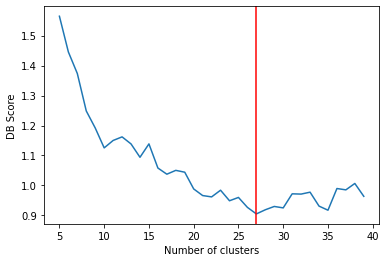

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

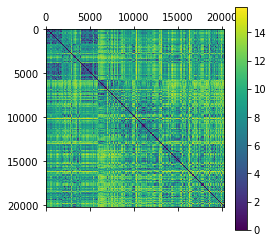

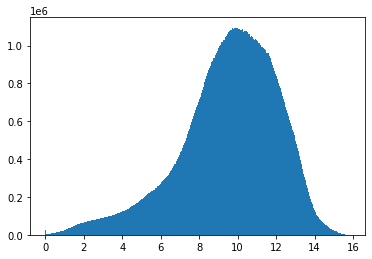

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

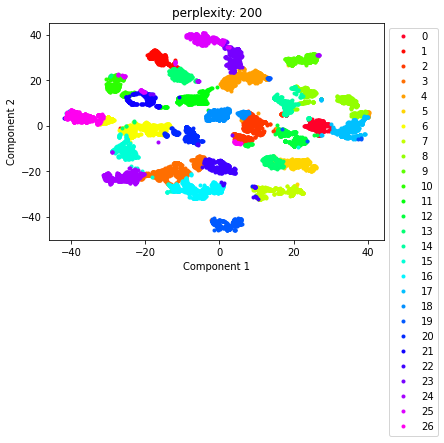

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9663923520425762


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.23297851082559695
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.988950276243094
layer 4: 0.9271408839779005
layer 5: 0.7726174033149171
layer 6: 0.5253798342541437
layer 7: 0.31677313535911605
layer 8: 0.20474361187845302
Epoch: 00 | Batch: 000 / 011 | Total loss: 3.302 | Reg loss: 0.019 | Tree loss: 3.302 | Accuracy: 0.045000 | 1.508 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 3.295 | Reg loss: 0.018 | Tree loss: 3.295 | Accuracy: 0.075500 | 1.287 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 3.289 | Reg loss: 0.018 | Tree loss: 3.289 | Accuracy: 0.128500 | 1.216 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 3.283 | Reg loss: 0.018 | Tree loss: 3.283 | Accuracy: 0.136500 | 1.146 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 3.275 | Reg loss: 0.017 | Tree loss: 3.275 | Accuracy: 0.150500 | 1.131 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 3.273 | Reg loss: 0.017 | Tree loss: 3.273 | Ac

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 3.255 | Reg loss: 0.015 | Tree loss: 3.255 | Accuracy: 0.166500 | 1.063 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 3.240 | Reg loss: 0.015 | Tree loss: 3.240 | Accuracy: 0.220500 | 1.063 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 3.220 | Reg loss: 0.015 | Tree loss: 3.220 | Accuracy: 0.219500 | 1.063 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 3.200 | Reg loss: 0.015 | Tree loss: 3.200 | Accuracy: 0.223500 | 1.062 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 3.183 | Reg loss: 0.015 | Tree loss: 3.183 | Accuracy: 0.197000 | 1.062 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.165 | Reg loss: 0.015 | Tree loss: 3.165 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 10 | Batch: 000 / 011 | Total loss: 3.154 | Reg loss: 0.017 | Tree loss: 3.154 | Accuracy: 0.265000 | 1.061 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 3.112 | Reg loss: 0.017 | Tree loss: 3.112 | Accuracy: 0.265000 | 1.06 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 3.064 | Reg loss: 0.017 | Tree loss: 3.064 | Accuracy: 0.267500 | 1.06 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.009 | Reg loss: 0.017 | Tree loss: 3.009 | Accuracy: 0.247500 | 1.06 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 2.980 | Reg loss: 0.018 | Tree loss: 2.980 | Accuracy: 0.242000 | 1.06 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 2.932 | Reg loss: 0.018 | Tree loss: 2.932 | Accur

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 15 | Batch: 000 / 011 | Total loss: 2.917 | Reg loss: 0.021 | Tree loss: 2.917 | Accuracy: 0.295500 | 1.06 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 2.884 | Reg loss: 0.021 | Tree loss: 2.884 | Accuracy: 0.271000 | 1.06 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 2.811 | Reg loss: 0.021 | Tree loss: 2.811 | Accuracy: 0.276000 | 1.06 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 2.781 | Reg loss: 0.021 | Tree loss: 2.781 | Accuracy: 0.253000 | 1.06 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 2.736 | Reg loss: 0.021 | Tree loss: 2.736 | Accuracy: 0.252000 | 1.06 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 2.708 | Reg loss: 0.021 | Tree loss: 2.708 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 20 | Batch: 000 / 011 | Total loss: 2.707 | Reg loss: 0.024 | Tree loss: 2.707 | Accuracy: 0.305500 | 1.059 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 2.658 | Reg loss: 0.024 | Tree loss: 2.658 | Accuracy: 0.289500 | 1.059 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 2.633 | Reg loss: 0.024 | Tree loss: 2.633 | Accuracy: 0.297500 | 1.059 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 2.563 | Reg loss: 0.024 | Tree loss: 2.563 | Accuracy: 0.291000 | 1.059 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 2.546 | Reg loss: 0.024 | Tree loss: 2.546 | Accuracy: 0.287500 | 1.059 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 2.491 | Reg loss: 0.024 | Tree loss: 2.491 | A

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 25 | Batch: 000 / 011 | Total loss: 2.526 | Reg loss: 0.026 | Tree loss: 2.526 | Accuracy: 0.331500 | 1.06 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 2.507 | Reg loss: 0.027 | Tree loss: 2.507 | Accuracy: 0.282500 | 1.06 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 2.471 | Reg loss: 0.027 | Tree loss: 2.471 | Accuracy: 0.292000 | 1.06 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 2.431 | Reg loss: 0.027 | Tree loss: 2.431 | Accuracy: 0.287500 | 1.06 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 2.389 | Reg loss: 0.027 | Tree loss: 2.389 | Accuracy: 0.302000 | 1.06 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 2.357 | Reg loss: 0.027 | Tree loss: 2.357 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 30 | Batch: 000 / 011 | Total loss: 2.450 | Reg loss: 0.028 | Tree loss: 2.450 | Accuracy: 0.288500 | 1.06 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 2.400 | Reg loss: 0.028 | Tree loss: 2.400 | Accuracy: 0.277500 | 1.06 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 2.359 | Reg loss: 0.028 | Tree loss: 2.359 | Accuracy: 0.302500 | 1.06 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 2.312 | Reg loss: 0.028 | Tree loss: 2.312 | Accuracy: 0.309000 | 1.06 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 2.274 | Reg loss: 0.028 | Tree loss: 2.274 | Accuracy: 0.332500 | 1.06 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 2.249 | Reg loss: 0.029 | Tree loss: 2.249 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 35 | Batch: 000 / 011 | Total loss: 2.383 | Reg loss: 0.030 | Tree loss: 2.383 | Accuracy: 0.277500 | 1.06 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 2.288 | Reg loss: 0.030 | Tree loss: 2.288 | Accuracy: 0.321000 | 1.06 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 2.271 | Reg loss: 0.030 | Tree loss: 2.271 | Accuracy: 0.306000 | 1.06 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 2.237 | Reg loss: 0.030 | Tree loss: 2.237 | Accuracy: 0.312000 | 1.06 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 2.209 | Reg loss: 0.030 | Tree loss: 2.209 | Accuracy: 0.320500 | 1.059 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 2.153 | Reg loss: 0.030 | Tree loss: 2.153 | Accur

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 40 | Batch: 000 / 011 | Total loss: 2.300 | Reg loss: 0.031 | Tree loss: 2.300 | Accuracy: 0.297500 | 1.06 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 2.256 | Reg loss: 0.031 | Tree loss: 2.256 | Accuracy: 0.288000 | 1.06 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 2.193 | Reg loss: 0.031 | Tree loss: 2.193 | Accuracy: 0.320500 | 1.06 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 2.180 | Reg loss: 0.031 | Tree loss: 2.180 | Accuracy: 0.315000 | 1.06 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 2.138 | Reg loss: 0.031 | Tree loss: 2.138 | Accuracy: 0.332000 | 1.06 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 2.082 | Reg loss: 0.031 | Tree loss: 2.082 | Accura

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 45 | Batch: 000 / 011 | Total loss: 2.234 | Reg loss: 0.032 | Tree loss: 2.234 | Accuracy: 0.317500 | 1.06 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 2.187 | Reg loss: 0.032 | Tree loss: 2.187 | Accuracy: 0.320000 | 1.06 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 2.146 | Reg loss: 0.032 | Tree loss: 2.146 | Accuracy: 0.315000 | 1.06 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 2.120 | Reg loss: 0.032 | Tree loss: 2.120 | Accuracy: 0.332000 | 1.06 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 2.114 | Reg loss: 0.032 | Tree loss: 2.114 | Accuracy: 0.320500 | 1.06 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 2.035 | Reg loss: 0.032 | Tree loss: 2.035 | Accura

Epoch: 50 | Batch: 000 / 011 | Total loss: 2.229 | Reg loss: 0.033 | Tree loss: 2.229 | Accuracy: 0.312000 | 1.058 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 2.158 | Reg loss: 0.033 | Tree loss: 2.158 | Accuracy: 0.315500 | 1.058 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 2.138 | Reg loss: 0.033 | Tree loss: 2.138 | Accuracy: 0.322000 | 1.058 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 2.052 | Reg loss: 0.033 | Tree loss: 2.052 | Accuracy: 0.347000 | 1.058 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 2.045 | Reg loss: 0.033 | Tree loss: 2.045 | Accuracy: 0.338000 | 1.057 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 1.994 | Reg loss: 0.033 | Tree loss: 1.994 | Accuracy: 0.347500 | 1.057 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 1.971 | Reg loss: 0.033 | Tree loss: 1.971 | Accuracy: 0.358000 | 1.057 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 1.967 | Reg loss: 0.033 | Tree loss: 1.967 | Accuracy: 0.357500 | 1.057 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 2.176 | Reg loss: 0.033 | Tree loss: 2.176 | Accuracy: 0.329500 | 1.046 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 2.130 | Reg loss: 0.033 | Tree loss: 2.130 | Accuracy: 0.329000 | 1.045 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 2.098 | Reg loss: 0.033 | Tree loss: 2.098 | Accuracy: 0.336000 | 1.045 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 2.045 | Reg loss: 0.034 | Tree loss: 2.045 | Accuracy: 0.341500 | 1.045 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 2.013 | Reg loss: 0.034 | Tree loss: 2.013 | Accuracy: 0.351000 | 1.045 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 1.955 | Reg loss: 0.034 | Tree loss: 1.955 | Accuracy: 0.364500 | 1.045 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 1.953 | Reg loss: 0.034 | Tree loss: 1.953 | Accuracy: 0.359000 | 1.044 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 1.915 | Reg loss: 0.034 | Tree loss: 1.915 | Accuracy: 0.383500 | 1.044 sec/iter
Epoch: 5

Epoch: 60 | Batch: 000 / 011 | Total loss: 2.149 | Reg loss: 0.034 | Tree loss: 2.149 | Accuracy: 0.326500 | 1.035 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 2.088 | Reg loss: 0.034 | Tree loss: 2.088 | Accuracy: 0.338500 | 1.034 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 2.072 | Reg loss: 0.034 | Tree loss: 2.072 | Accuracy: 0.339000 | 1.034 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 2.027 | Reg loss: 0.034 | Tree loss: 2.027 | Accuracy: 0.345500 | 1.034 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 1.993 | Reg loss: 0.034 | Tree loss: 1.993 | Accuracy: 0.354000 | 1.034 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 1.955 | Reg loss: 0.034 | Tree loss: 1.955 | Accuracy: 0.352500 | 1.034 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 1.929 | Reg loss: 0.034 | Tree loss: 1.929 | Accuracy: 0.380000 | 1.034 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 1.926 | Reg loss: 0.034 | Tree loss: 1.926 | Accuracy: 0.393500 | 1.033 sec/iter
Epoch: 6

Epoch: 65 | Batch: 000 / 011 | Total loss: 2.112 | Reg loss: 0.035 | Tree loss: 2.112 | Accuracy: 0.338000 | 1.025 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 2.066 | Reg loss: 0.035 | Tree loss: 2.066 | Accuracy: 0.327500 | 1.025 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 2.033 | Reg loss: 0.035 | Tree loss: 2.033 | Accuracy: 0.351000 | 1.025 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 1.995 | Reg loss: 0.035 | Tree loss: 1.995 | Accuracy: 0.352500 | 1.025 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 1.961 | Reg loss: 0.035 | Tree loss: 1.961 | Accuracy: 0.358500 | 1.024 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 1.945 | Reg loss: 0.035 | Tree loss: 1.945 | Accuracy: 0.366500 | 1.024 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 1.911 | Reg loss: 0.035 | Tree loss: 1.911 | Accuracy: 0.399500 | 1.024 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 1.888 | Reg loss: 0.035 | Tree loss: 1.888 | Accuracy: 0.386000 | 1.024 sec/iter
Epoch: 6

Epoch: 70 | Batch: 000 / 011 | Total loss: 2.100 | Reg loss: 0.036 | Tree loss: 2.100 | Accuracy: 0.332500 | 1.017 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 2.051 | Reg loss: 0.036 | Tree loss: 2.051 | Accuracy: 0.347000 | 1.017 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 2.005 | Reg loss: 0.036 | Tree loss: 2.005 | Accuracy: 0.363000 | 1.017 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 1.958 | Reg loss: 0.036 | Tree loss: 1.958 | Accuracy: 0.363000 | 1.017 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 1.942 | Reg loss: 0.036 | Tree loss: 1.942 | Accuracy: 0.369000 | 1.017 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 1.906 | Reg loss: 0.036 | Tree loss: 1.906 | Accuracy: 0.389000 | 1.017 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 1.883 | Reg loss: 0.036 | Tree loss: 1.883 | Accuracy: 0.386000 | 1.016 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 1.861 | Reg loss: 0.036 | Tree loss: 1.861 | Accuracy: 0.399000 | 1.016 sec/iter
Epoch: 7

Epoch: 75 | Batch: 000 / 011 | Total loss: 2.091 | Reg loss: 0.036 | Tree loss: 2.091 | Accuracy: 0.324000 | 1.01 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 2.050 | Reg loss: 0.036 | Tree loss: 2.050 | Accuracy: 0.346000 | 1.01 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 1.965 | Reg loss: 0.036 | Tree loss: 1.965 | Accuracy: 0.366000 | 1.01 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 1.953 | Reg loss: 0.036 | Tree loss: 1.953 | Accuracy: 0.337000 | 1.01 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 1.888 | Reg loss: 0.036 | Tree loss: 1.888 | Accuracy: 0.398500 | 1.01 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 1.894 | Reg loss: 0.036 | Tree loss: 1.894 | Accuracy: 0.389000 | 1.01 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 1.887 | Reg loss: 0.036 | Tree loss: 1.887 | Accuracy: 0.382500 | 1.01 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 1.837 | Reg loss: 0.036 | Tree loss: 1.837 | Accuracy: 0.408500 | 1.01 sec/iter
Epoch: 75 | Batc

Epoch: 80 | Batch: 000 / 011 | Total loss: 2.034 | Reg loss: 0.037 | Tree loss: 2.034 | Accuracy: 0.350000 | 1.004 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 1.993 | Reg loss: 0.037 | Tree loss: 1.993 | Accuracy: 0.354000 | 1.004 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 1.967 | Reg loss: 0.037 | Tree loss: 1.967 | Accuracy: 0.349000 | 1.004 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 1.947 | Reg loss: 0.037 | Tree loss: 1.947 | Accuracy: 0.344000 | 1.004 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 1.892 | Reg loss: 0.037 | Tree loss: 1.892 | Accuracy: 0.380500 | 1.004 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 1.852 | Reg loss: 0.037 | Tree loss: 1.852 | Accuracy: 0.393000 | 1.004 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 1.872 | Reg loss: 0.037 | Tree loss: 1.872 | Accuracy: 0.397000 | 1.004 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 1.853 | Reg loss: 0.037 | Tree loss: 1.853 | Accuracy: 0.405500 | 1.004 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 2.053 | Reg loss: 0.037 | Tree loss: 2.053 | Accuracy: 0.341500 | 0.999 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 1.975 | Reg loss: 0.037 | Tree loss: 1.975 | Accuracy: 0.370000 | 0.999 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 1.944 | Reg loss: 0.037 | Tree loss: 1.944 | Accuracy: 0.357500 | 0.999 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 1.932 | Reg loss: 0.037 | Tree loss: 1.932 | Accuracy: 0.366000 | 0.999 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 1.874 | Reg loss: 0.037 | Tree loss: 1.874 | Accuracy: 0.385000 | 0.999 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 1.847 | Reg loss: 0.037 | Tree loss: 1.847 | Accuracy: 0.403500 | 0.999 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 1.827 | Reg loss: 0.037 | Tree loss: 1.827 | Accuracy: 0.423000 | 0.999 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 1.836 | Reg loss: 0.037 | Tree loss: 1.836 | Accuracy: 0.399000 | 0.998 sec/iter
Epoch: 8

Epoch: 90 | Batch: 000 / 011 | Total loss: 2.038 | Reg loss: 0.038 | Tree loss: 2.038 | Accuracy: 0.335500 | 0.994 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 2.005 | Reg loss: 0.038 | Tree loss: 2.005 | Accuracy: 0.339000 | 0.994 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 1.947 | Reg loss: 0.038 | Tree loss: 1.947 | Accuracy: 0.351000 | 0.994 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 1.915 | Reg loss: 0.038 | Tree loss: 1.915 | Accuracy: 0.357000 | 0.994 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 1.863 | Reg loss: 0.038 | Tree loss: 1.863 | Accuracy: 0.391500 | 0.994 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 1.838 | Reg loss: 0.038 | Tree loss: 1.838 | Accuracy: 0.404500 | 0.994 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 1.796 | Reg loss: 0.038 | Tree loss: 1.796 | Accuracy: 0.424000 | 0.994 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 1.809 | Reg loss: 0.038 | Tree loss: 1.809 | Accuracy: 0.415500 | 0.994 sec/iter
Epoch: 9

Epoch: 95 | Batch: 000 / 011 | Total loss: 1.999 | Reg loss: 0.038 | Tree loss: 1.999 | Accuracy: 0.370500 | 0.99 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 1.968 | Reg loss: 0.038 | Tree loss: 1.968 | Accuracy: 0.354500 | 0.99 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 1.915 | Reg loss: 0.038 | Tree loss: 1.915 | Accuracy: 0.367000 | 0.99 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 1.894 | Reg loss: 0.038 | Tree loss: 1.894 | Accuracy: 0.371500 | 0.99 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 1.870 | Reg loss: 0.038 | Tree loss: 1.870 | Accuracy: 0.375500 | 0.99 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 1.843 | Reg loss: 0.038 | Tree loss: 1.843 | Accuracy: 0.384000 | 0.99 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 1.809 | Reg loss: 0.038 | Tree loss: 1.809 | Accuracy: 0.428000 | 0.99 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 1.792 | Reg loss: 0.038 | Tree loss: 1.792 | Accuracy: 0.406000 | 0.989 sec/iter
Epoch: 95 | Bat

Epoch: 100 | Batch: 000 / 011 | Total loss: 1.962 | Reg loss: 0.038 | Tree loss: 1.962 | Accuracy: 0.361000 | 0.986 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 1.955 | Reg loss: 0.038 | Tree loss: 1.955 | Accuracy: 0.351500 | 0.986 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 1.912 | Reg loss: 0.038 | Tree loss: 1.912 | Accuracy: 0.358500 | 0.986 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 1.889 | Reg loss: 0.038 | Tree loss: 1.889 | Accuracy: 0.381000 | 0.986 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 1.857 | Reg loss: 0.038 | Tree loss: 1.857 | Accuracy: 0.395500 | 0.986 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 1.813 | Reg loss: 0.038 | Tree loss: 1.813 | Accuracy: 0.421000 | 0.986 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 1.805 | Reg loss: 0.038 | Tree loss: 1.805 | Accuracy: 0.422000 | 0.986 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 1.787 | Reg loss: 0.039 | Tree loss: 1.787 | Accuracy: 0.431500 | 0.985 sec/iter


Epoch: 105 | Batch: 000 / 011 | Total loss: 1.958 | Reg loss: 0.039 | Tree loss: 1.958 | Accuracy: 0.373500 | 0.982 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 1.945 | Reg loss: 0.039 | Tree loss: 1.945 | Accuracy: 0.344000 | 0.982 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 1.923 | Reg loss: 0.039 | Tree loss: 1.923 | Accuracy: 0.368000 | 0.982 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 1.873 | Reg loss: 0.039 | Tree loss: 1.873 | Accuracy: 0.380500 | 0.982 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 1.831 | Reg loss: 0.039 | Tree loss: 1.831 | Accuracy: 0.411000 | 0.982 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 1.812 | Reg loss: 0.039 | Tree loss: 1.812 | Accuracy: 0.414000 | 0.982 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 1.799 | Reg loss: 0.039 | Tree loss: 1.799 | Accuracy: 0.421000 | 0.982 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 1.772 | Reg loss: 0.039 | Tree loss: 1.772 | Accuracy: 0.420500 | 0.982 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 1.950 | Reg loss: 0.039 | Tree loss: 1.950 | Accuracy: 0.370500 | 0.979 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 1.917 | Reg loss: 0.039 | Tree loss: 1.917 | Accuracy: 0.374500 | 0.979 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 1.906 | Reg loss: 0.039 | Tree loss: 1.906 | Accuracy: 0.355000 | 0.979 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 1.868 | Reg loss: 0.039 | Tree loss: 1.868 | Accuracy: 0.375500 | 0.979 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 1.824 | Reg loss: 0.039 | Tree loss: 1.824 | Accuracy: 0.384500 | 0.979 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 1.805 | Reg loss: 0.039 | Tree loss: 1.805 | Accuracy: 0.410000 | 0.979 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 1.778 | Reg loss: 0.039 | Tree loss: 1.778 | Accuracy: 0.399000 | 0.979 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 1.786 | Reg loss: 0.039 | Tree loss: 1.786 | Accuracy: 0.415500 | 0.979 sec/iter


Epoch: 115 | Batch: 000 / 011 | Total loss: 1.946 | Reg loss: 0.039 | Tree loss: 1.946 | Accuracy: 0.364500 | 0.976 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 1.919 | Reg loss: 0.039 | Tree loss: 1.919 | Accuracy: 0.363500 | 0.976 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 1.888 | Reg loss: 0.039 | Tree loss: 1.888 | Accuracy: 0.381500 | 0.976 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 1.870 | Reg loss: 0.039 | Tree loss: 1.870 | Accuracy: 0.372000 | 0.976 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 1.809 | Reg loss: 0.039 | Tree loss: 1.809 | Accuracy: 0.425500 | 0.976 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 1.795 | Reg loss: 0.039 | Tree loss: 1.795 | Accuracy: 0.427000 | 0.976 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 1.779 | Reg loss: 0.039 | Tree loss: 1.779 | Accuracy: 0.417500 | 0.976 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 1.772 | Reg loss: 0.039 | Tree loss: 1.772 | Accuracy: 0.404000 | 0.976 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 1.966 | Reg loss: 0.040 | Tree loss: 1.966 | Accuracy: 0.344500 | 0.974 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 1.904 | Reg loss: 0.040 | Tree loss: 1.904 | Accuracy: 0.370500 | 0.974 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 1.877 | Reg loss: 0.040 | Tree loss: 1.877 | Accuracy: 0.369500 | 0.973 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 1.831 | Reg loss: 0.040 | Tree loss: 1.831 | Accuracy: 0.396000 | 0.973 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 1.823 | Reg loss: 0.040 | Tree loss: 1.823 | Accuracy: 0.391500 | 0.973 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 1.781 | Reg loss: 0.040 | Tree loss: 1.781 | Accuracy: 0.411500 | 0.973 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 1.783 | Reg loss: 0.040 | Tree loss: 1.783 | Accuracy: 0.410500 | 0.973 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 1.730 | Reg loss: 0.040 | Tree loss: 1.730 | Accuracy: 0.426000 | 0.973 sec/iter


Epoch: 125 | Batch: 000 / 011 | Total loss: 1.938 | Reg loss: 0.040 | Tree loss: 1.938 | Accuracy: 0.372500 | 0.971 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 1.908 | Reg loss: 0.040 | Tree loss: 1.908 | Accuracy: 0.374000 | 0.971 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 1.864 | Reg loss: 0.040 | Tree loss: 1.864 | Accuracy: 0.398000 | 0.971 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 1.833 | Reg loss: 0.040 | Tree loss: 1.833 | Accuracy: 0.402500 | 0.971 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 1.810 | Reg loss: 0.040 | Tree loss: 1.810 | Accuracy: 0.420000 | 0.971 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 1.766 | Reg loss: 0.040 | Tree loss: 1.766 | Accuracy: 0.423000 | 0.971 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 1.774 | Reg loss: 0.040 | Tree loss: 1.774 | Accuracy: 0.405000 | 0.971 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 1.735 | Reg loss: 0.040 | Tree loss: 1.735 | Accuracy: 0.425500 | 0.971 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 1.937 | Reg loss: 0.040 | Tree loss: 1.937 | Accuracy: 0.377500 | 0.969 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 1.893 | Reg loss: 0.040 | Tree loss: 1.893 | Accuracy: 0.371000 | 0.969 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 1.861 | Reg loss: 0.040 | Tree loss: 1.861 | Accuracy: 0.390500 | 0.969 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 1.811 | Reg loss: 0.040 | Tree loss: 1.811 | Accuracy: 0.403500 | 0.969 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 1.815 | Reg loss: 0.040 | Tree loss: 1.815 | Accuracy: 0.391000 | 0.969 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 1.791 | Reg loss: 0.040 | Tree loss: 1.791 | Accuracy: 0.418500 | 0.969 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 1.764 | Reg loss: 0.040 | Tree loss: 1.764 | Accuracy: 0.417000 | 0.969 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 1.745 | Reg loss: 0.040 | Tree loss: 1.745 | Accuracy: 0.418000 | 0.968 sec/iter


Epoch: 135 | Batch: 000 / 011 | Total loss: 1.916 | Reg loss: 0.040 | Tree loss: 1.916 | Accuracy: 0.389000 | 0.967 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 1.887 | Reg loss: 0.040 | Tree loss: 1.887 | Accuracy: 0.397500 | 0.967 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 1.853 | Reg loss: 0.040 | Tree loss: 1.853 | Accuracy: 0.387000 | 0.967 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 1.822 | Reg loss: 0.040 | Tree loss: 1.822 | Accuracy: 0.405000 | 0.967 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 1.770 | Reg loss: 0.040 | Tree loss: 1.770 | Accuracy: 0.422000 | 0.967 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 1.806 | Reg loss: 0.040 | Tree loss: 1.806 | Accuracy: 0.409500 | 0.967 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 1.741 | Reg loss: 0.040 | Tree loss: 1.741 | Accuracy: 0.431000 | 0.967 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 1.762 | Reg loss: 0.040 | Tree loss: 1.762 | Accuracy: 0.415500 | 0.967 sec/iter


Epoch: 140 | Batch: 000 / 011 | Total loss: 1.930 | Reg loss: 0.040 | Tree loss: 1.930 | Accuracy: 0.373500 | 0.965 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 1.899 | Reg loss: 0.040 | Tree loss: 1.899 | Accuracy: 0.385500 | 0.965 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 1.856 | Reg loss: 0.040 | Tree loss: 1.856 | Accuracy: 0.374500 | 0.965 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 1.825 | Reg loss: 0.040 | Tree loss: 1.825 | Accuracy: 0.403500 | 0.965 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 1.790 | Reg loss: 0.040 | Tree loss: 1.790 | Accuracy: 0.405000 | 0.965 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 1.758 | Reg loss: 0.040 | Tree loss: 1.758 | Accuracy: 0.429000 | 0.965 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 1.744 | Reg loss: 0.040 | Tree loss: 1.744 | Accuracy: 0.418000 | 0.965 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 1.732 | Reg loss: 0.040 | Tree loss: 1.732 | Accuracy: 0.418500 | 0.965 sec/iter


Epoch: 145 | Batch: 000 / 011 | Total loss: 1.904 | Reg loss: 0.040 | Tree loss: 1.904 | Accuracy: 0.374000 | 0.963 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 1.888 | Reg loss: 0.040 | Tree loss: 1.888 | Accuracy: 0.390500 | 0.963 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 1.856 | Reg loss: 0.040 | Tree loss: 1.856 | Accuracy: 0.404000 | 0.963 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 1.814 | Reg loss: 0.040 | Tree loss: 1.814 | Accuracy: 0.407500 | 0.963 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 1.771 | Reg loss: 0.040 | Tree loss: 1.771 | Accuracy: 0.426000 | 0.963 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 1.776 | Reg loss: 0.040 | Tree loss: 1.776 | Accuracy: 0.409000 | 0.963 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 1.745 | Reg loss: 0.041 | Tree loss: 1.745 | Accuracy: 0.423500 | 0.963 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 1.740 | Reg loss: 0.041 | Tree loss: 1.740 | Accuracy: 0.419500 | 0.963 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 1.901 | Reg loss: 0.041 | Tree loss: 1.901 | Accuracy: 0.375000 | 0.961 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 1.853 | Reg loss: 0.041 | Tree loss: 1.853 | Accuracy: 0.394500 | 0.961 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 1.845 | Reg loss: 0.041 | Tree loss: 1.845 | Accuracy: 0.406500 | 0.961 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 1.837 | Reg loss: 0.041 | Tree loss: 1.837 | Accuracy: 0.378500 | 0.961 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 1.811 | Reg loss: 0.041 | Tree loss: 1.811 | Accuracy: 0.397000 | 0.961 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 1.758 | Reg loss: 0.041 | Tree loss: 1.758 | Accuracy: 0.423500 | 0.961 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 1.738 | Reg loss: 0.041 | Tree loss: 1.738 | Accuracy: 0.425500 | 0.961 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 1.732 | Reg loss: 0.041 | Tree loss: 1.732 | Accuracy: 0.421000 | 0.961 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 1.884 | Reg loss: 0.041 | Tree loss: 1.884 | Accuracy: 0.388500 | 0.96 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 1.863 | Reg loss: 0.041 | Tree loss: 1.863 | Accuracy: 0.402500 | 0.96 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 1.837 | Reg loss: 0.041 | Tree loss: 1.837 | Accuracy: 0.400500 | 0.96 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 1.812 | Reg loss: 0.041 | Tree loss: 1.812 | Accuracy: 0.412000 | 0.96 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 1.790 | Reg loss: 0.041 | Tree loss: 1.790 | Accuracy: 0.405000 | 0.96 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 1.748 | Reg loss: 0.041 | Tree loss: 1.748 | Accuracy: 0.435500 | 0.96 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 1.758 | Reg loss: 0.041 | Tree loss: 1.758 | Accuracy: 0.417500 | 0.96 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 1.732 | Reg loss: 0.041 | Tree loss: 1.732 | Accuracy: 0.410000 | 0.96 sec/iter
Epoch: 1

Epoch: 160 | Batch: 000 / 011 | Total loss: 1.875 | Reg loss: 0.041 | Tree loss: 1.875 | Accuracy: 0.400000 | 0.958 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 1.863 | Reg loss: 0.041 | Tree loss: 1.863 | Accuracy: 0.403500 | 0.958 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 1.813 | Reg loss: 0.041 | Tree loss: 1.813 | Accuracy: 0.416500 | 0.958 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 1.814 | Reg loss: 0.041 | Tree loss: 1.814 | Accuracy: 0.402500 | 0.958 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 1.807 | Reg loss: 0.041 | Tree loss: 1.807 | Accuracy: 0.394500 | 0.958 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 1.751 | Reg loss: 0.041 | Tree loss: 1.751 | Accuracy: 0.441000 | 0.958 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 1.744 | Reg loss: 0.041 | Tree loss: 1.744 | Accuracy: 0.412000 | 0.958 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 1.715 | Reg loss: 0.041 | Tree loss: 1.715 | Accuracy: 0.408500 | 0.958 sec/iter


Epoch: 165 | Batch: 000 / 011 | Total loss: 1.853 | Reg loss: 0.041 | Tree loss: 1.853 | Accuracy: 0.399000 | 0.957 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 1.864 | Reg loss: 0.041 | Tree loss: 1.864 | Accuracy: 0.400500 | 0.957 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 1.840 | Reg loss: 0.041 | Tree loss: 1.840 | Accuracy: 0.383500 | 0.957 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 1.796 | Reg loss: 0.041 | Tree loss: 1.796 | Accuracy: 0.410500 | 0.957 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 1.780 | Reg loss: 0.041 | Tree loss: 1.780 | Accuracy: 0.421000 | 0.957 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 1.753 | Reg loss: 0.041 | Tree loss: 1.753 | Accuracy: 0.421000 | 0.957 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 1.745 | Reg loss: 0.041 | Tree loss: 1.745 | Accuracy: 0.409500 | 0.957 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 1.710 | Reg loss: 0.041 | Tree loss: 1.710 | Accuracy: 0.425000 | 0.957 sec/iter


Epoch: 170 | Batch: 000 / 011 | Total loss: 1.909 | Reg loss: 0.041 | Tree loss: 1.909 | Accuracy: 0.381000 | 0.956 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 1.868 | Reg loss: 0.041 | Tree loss: 1.868 | Accuracy: 0.393500 | 0.956 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 1.799 | Reg loss: 0.041 | Tree loss: 1.799 | Accuracy: 0.417000 | 0.956 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 1.815 | Reg loss: 0.041 | Tree loss: 1.815 | Accuracy: 0.382500 | 0.956 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 1.749 | Reg loss: 0.041 | Tree loss: 1.749 | Accuracy: 0.417000 | 0.955 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 1.757 | Reg loss: 0.041 | Tree loss: 1.757 | Accuracy: 0.418000 | 0.955 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 1.705 | Reg loss: 0.041 | Tree loss: 1.705 | Accuracy: 0.428000 | 0.955 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 1.730 | Reg loss: 0.041 | Tree loss: 1.730 | Accuracy: 0.413000 | 0.955 sec/iter


Epoch: 175 | Batch: 000 / 011 | Total loss: 1.894 | Reg loss: 0.041 | Tree loss: 1.894 | Accuracy: 0.395500 | 0.954 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 1.840 | Reg loss: 0.041 | Tree loss: 1.840 | Accuracy: 0.424500 | 0.954 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 1.811 | Reg loss: 0.041 | Tree loss: 1.811 | Accuracy: 0.410000 | 0.954 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 1.787 | Reg loss: 0.041 | Tree loss: 1.787 | Accuracy: 0.424500 | 0.954 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 1.806 | Reg loss: 0.041 | Tree loss: 1.806 | Accuracy: 0.403500 | 0.954 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 1.752 | Reg loss: 0.041 | Tree loss: 1.752 | Accuracy: 0.421000 | 0.954 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 1.751 | Reg loss: 0.041 | Tree loss: 1.751 | Accuracy: 0.408500 | 0.954 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 1.723 | Reg loss: 0.041 | Tree loss: 1.723 | Accuracy: 0.408000 | 0.954 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 1.879 | Reg loss: 0.041 | Tree loss: 1.879 | Accuracy: 0.399500 | 0.953 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 1.853 | Reg loss: 0.041 | Tree loss: 1.853 | Accuracy: 0.376500 | 0.953 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 1.809 | Reg loss: 0.041 | Tree loss: 1.809 | Accuracy: 0.414000 | 0.953 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 1.814 | Reg loss: 0.041 | Tree loss: 1.814 | Accuracy: 0.386500 | 0.953 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 1.759 | Reg loss: 0.041 | Tree loss: 1.759 | Accuracy: 0.424500 | 0.953 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 1.738 | Reg loss: 0.041 | Tree loss: 1.738 | Accuracy: 0.430000 | 0.953 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 1.735 | Reg loss: 0.041 | Tree loss: 1.735 | Accuracy: 0.426000 | 0.953 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 1.719 | Reg loss: 0.041 | Tree loss: 1.719 | Accuracy: 0.433000 | 0.953 sec/iter


Epoch: 185 | Batch: 000 / 011 | Total loss: 1.892 | Reg loss: 0.041 | Tree loss: 1.892 | Accuracy: 0.394500 | 0.952 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 1.865 | Reg loss: 0.041 | Tree loss: 1.865 | Accuracy: 0.387500 | 0.952 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 1.801 | Reg loss: 0.041 | Tree loss: 1.801 | Accuracy: 0.409500 | 0.952 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 1.789 | Reg loss: 0.041 | Tree loss: 1.789 | Accuracy: 0.409000 | 0.952 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 1.765 | Reg loss: 0.041 | Tree loss: 1.765 | Accuracy: 0.407500 | 0.952 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 1.718 | Reg loss: 0.041 | Tree loss: 1.718 | Accuracy: 0.428000 | 0.952 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 1.744 | Reg loss: 0.041 | Tree loss: 1.744 | Accuracy: 0.415000 | 0.952 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 1.741 | Reg loss: 0.041 | Tree loss: 1.741 | Accuracy: 0.412000 | 0.952 sec/iter


Epoch: 190 | Batch: 000 / 011 | Total loss: 1.872 | Reg loss: 0.041 | Tree loss: 1.872 | Accuracy: 0.418500 | 0.951 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 1.855 | Reg loss: 0.041 | Tree loss: 1.855 | Accuracy: 0.379500 | 0.951 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 1.780 | Reg loss: 0.041 | Tree loss: 1.780 | Accuracy: 0.422500 | 0.951 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 1.768 | Reg loss: 0.041 | Tree loss: 1.768 | Accuracy: 0.428000 | 0.951 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 1.776 | Reg loss: 0.041 | Tree loss: 1.776 | Accuracy: 0.417500 | 0.951 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 1.764 | Reg loss: 0.042 | Tree loss: 1.764 | Accuracy: 0.408000 | 0.951 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 1.739 | Reg loss: 0.042 | Tree loss: 1.739 | Accuracy: 0.421500 | 0.951 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 1.734 | Reg loss: 0.042 | Tree loss: 1.734 | Accuracy: 0.403000 | 0.951 sec/iter


Epoch: 195 | Batch: 000 / 011 | Total loss: 1.834 | Reg loss: 0.042 | Tree loss: 1.834 | Accuracy: 0.412500 | 0.95 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 1.856 | Reg loss: 0.042 | Tree loss: 1.856 | Accuracy: 0.389500 | 0.95 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 1.820 | Reg loss: 0.042 | Tree loss: 1.820 | Accuracy: 0.402000 | 0.95 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 1.748 | Reg loss: 0.042 | Tree loss: 1.748 | Accuracy: 0.423000 | 0.95 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 1.757 | Reg loss: 0.042 | Tree loss: 1.757 | Accuracy: 0.409500 | 0.95 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 1.739 | Reg loss: 0.042 | Tree loss: 1.739 | Accuracy: 0.410000 | 0.95 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 1.740 | Reg loss: 0.042 | Tree loss: 1.740 | Accuracy: 0.410500 | 0.95 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 1.745 | Reg loss: 0.042 | Tree loss: 1.745 | Accuracy: 0.424000 | 0.95 sec/iter
Epoch: 1

Epoch: 200 | Batch: 000 / 011 | Total loss: 1.898 | Reg loss: 0.042 | Tree loss: 1.898 | Accuracy: 0.389500 | 0.949 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 1.836 | Reg loss: 0.042 | Tree loss: 1.836 | Accuracy: 0.416500 | 0.949 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 1.823 | Reg loss: 0.042 | Tree loss: 1.823 | Accuracy: 0.404500 | 0.949 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 1.781 | Reg loss: 0.042 | Tree loss: 1.781 | Accuracy: 0.404500 | 0.949 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 1.768 | Reg loss: 0.042 | Tree loss: 1.768 | Accuracy: 0.402000 | 0.949 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 1.755 | Reg loss: 0.042 | Tree loss: 1.755 | Accuracy: 0.422000 | 0.949 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 1.690 | Reg loss: 0.042 | Tree loss: 1.690 | Accuracy: 0.444000 | 0.949 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 1.724 | Reg loss: 0.042 | Tree loss: 1.724 | Accuracy: 0.416000 | 0.949 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 1.843 | Reg loss: 0.042 | Tree loss: 1.843 | Accuracy: 0.415500 | 0.948 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 1.836 | Reg loss: 0.042 | Tree loss: 1.836 | Accuracy: 0.398500 | 0.948 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 1.810 | Reg loss: 0.042 | Tree loss: 1.810 | Accuracy: 0.405000 | 0.948 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 1.761 | Reg loss: 0.042 | Tree loss: 1.761 | Accuracy: 0.431500 | 0.948 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 1.764 | Reg loss: 0.042 | Tree loss: 1.764 | Accuracy: 0.424000 | 0.948 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.042 | Tree loss: 1.742 | Accuracy: 0.415500 | 0.948 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 1.706 | Reg loss: 0.042 | Tree loss: 1.706 | Accuracy: 0.424500 | 0.948 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 1.730 | Reg loss: 0.042 | Tree loss: 1.730 | Accuracy: 0.406500 | 0.948 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 1.864 | Reg loss: 0.042 | Tree loss: 1.864 | Accuracy: 0.390500 | 0.947 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 1.856 | Reg loss: 0.042 | Tree loss: 1.856 | Accuracy: 0.400000 | 0.947 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 1.801 | Reg loss: 0.042 | Tree loss: 1.801 | Accuracy: 0.403000 | 0.947 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 1.776 | Reg loss: 0.042 | Tree loss: 1.776 | Accuracy: 0.426500 | 0.947 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 1.751 | Reg loss: 0.042 | Tree loss: 1.751 | Accuracy: 0.419500 | 0.947 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 1.704 | Reg loss: 0.042 | Tree loss: 1.704 | Accuracy: 0.433500 | 0.947 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 1.728 | Reg loss: 0.042 | Tree loss: 1.728 | Accuracy: 0.407000 | 0.947 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 1.709 | Reg loss: 0.042 | Tree loss: 1.709 | Accuracy: 0.426000 | 0.947 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 1.868 | Reg loss: 0.042 | Tree loss: 1.868 | Accuracy: 0.393500 | 0.947 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 1.852 | Reg loss: 0.042 | Tree loss: 1.852 | Accuracy: 0.398500 | 0.947 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 1.805 | Reg loss: 0.042 | Tree loss: 1.805 | Accuracy: 0.423000 | 0.947 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 1.791 | Reg loss: 0.042 | Tree loss: 1.791 | Accuracy: 0.420000 | 0.947 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 1.764 | Reg loss: 0.042 | Tree loss: 1.764 | Accuracy: 0.412500 | 0.947 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 1.735 | Reg loss: 0.042 | Tree loss: 1.735 | Accuracy: 0.417000 | 0.947 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 1.705 | Reg loss: 0.042 | Tree loss: 1.705 | Accuracy: 0.418000 | 0.947 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 1.704 | Reg loss: 0.042 | Tree loss: 1.704 | Accuracy: 0.437500 | 0.947 sec/iter


Epoch: 220 | Batch: 000 / 011 | Total loss: 1.850 | Reg loss: 0.042 | Tree loss: 1.850 | Accuracy: 0.401500 | 0.946 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 1.828 | Reg loss: 0.042 | Tree loss: 1.828 | Accuracy: 0.415500 | 0.946 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 1.814 | Reg loss: 0.042 | Tree loss: 1.814 | Accuracy: 0.399000 | 0.946 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 1.799 | Reg loss: 0.042 | Tree loss: 1.799 | Accuracy: 0.412500 | 0.946 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.042 | Tree loss: 1.741 | Accuracy: 0.429000 | 0.946 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 1.745 | Reg loss: 0.042 | Tree loss: 1.745 | Accuracy: 0.408000 | 0.946 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 1.729 | Reg loss: 0.042 | Tree loss: 1.729 | Accuracy: 0.415000 | 0.946 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 1.705 | Reg loss: 0.042 | Tree loss: 1.705 | Accuracy: 0.427000 | 0.946 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 1.864 | Reg loss: 0.042 | Tree loss: 1.864 | Accuracy: 0.409000 | 0.945 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 1.839 | Reg loss: 0.042 | Tree loss: 1.839 | Accuracy: 0.410000 | 0.945 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 1.815 | Reg loss: 0.042 | Tree loss: 1.815 | Accuracy: 0.415500 | 0.945 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 1.779 | Reg loss: 0.042 | Tree loss: 1.779 | Accuracy: 0.418000 | 0.945 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 1.754 | Reg loss: 0.042 | Tree loss: 1.754 | Accuracy: 0.420500 | 0.945 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 1.729 | Reg loss: 0.042 | Tree loss: 1.729 | Accuracy: 0.429000 | 0.945 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 1.743 | Reg loss: 0.042 | Tree loss: 1.743 | Accuracy: 0.406500 | 0.945 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 1.718 | Reg loss: 0.042 | Tree loss: 1.718 | Accuracy: 0.404000 | 0.945 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 1.833 | Reg loss: 0.042 | Tree loss: 1.833 | Accuracy: 0.421500 | 0.945 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 1.831 | Reg loss: 0.042 | Tree loss: 1.831 | Accuracy: 0.404000 | 0.945 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 1.798 | Reg loss: 0.042 | Tree loss: 1.798 | Accuracy: 0.428000 | 0.945 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 1.800 | Reg loss: 0.042 | Tree loss: 1.800 | Accuracy: 0.408500 | 0.945 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.042 | Tree loss: 1.761 | Accuracy: 0.409500 | 0.945 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 1.734 | Reg loss: 0.042 | Tree loss: 1.734 | Accuracy: 0.429000 | 0.945 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 1.689 | Reg loss: 0.042 | Tree loss: 1.689 | Accuracy: 0.435500 | 0.945 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.042 | Tree loss: 1.686 | Accuracy: 0.430000 | 0.944 sec/iter


Epoch: 235 | Batch: 000 / 011 | Total loss: 1.860 | Reg loss: 0.042 | Tree loss: 1.860 | Accuracy: 0.410000 | 0.944 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 1.826 | Reg loss: 0.042 | Tree loss: 1.826 | Accuracy: 0.411000 | 0.944 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 1.807 | Reg loss: 0.042 | Tree loss: 1.807 | Accuracy: 0.424000 | 0.944 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 1.771 | Reg loss: 0.042 | Tree loss: 1.771 | Accuracy: 0.417500 | 0.944 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 1.763 | Reg loss: 0.042 | Tree loss: 1.763 | Accuracy: 0.429000 | 0.944 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 1.721 | Reg loss: 0.042 | Tree loss: 1.721 | Accuracy: 0.419500 | 0.944 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 1.703 | Reg loss: 0.042 | Tree loss: 1.703 | Accuracy: 0.424500 | 0.944 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.042 | Tree loss: 1.708 | Accuracy: 0.417000 | 0.944 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 1.850 | Reg loss: 0.042 | Tree loss: 1.850 | Accuracy: 0.434000 | 0.943 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 1.837 | Reg loss: 0.042 | Tree loss: 1.837 | Accuracy: 0.412500 | 0.943 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 1.813 | Reg loss: 0.042 | Tree loss: 1.813 | Accuracy: 0.404000 | 0.943 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.042 | Tree loss: 1.790 | Accuracy: 0.405500 | 0.943 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 1.728 | Reg loss: 0.042 | Tree loss: 1.728 | Accuracy: 0.410500 | 0.943 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 1.721 | Reg loss: 0.042 | Tree loss: 1.721 | Accuracy: 0.423500 | 0.943 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.042 | Tree loss: 1.709 | Accuracy: 0.426500 | 0.943 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 1.697 | Reg loss: 0.042 | Tree loss: 1.697 | Accuracy: 0.423000 | 0.943 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 1.862 | Reg loss: 0.042 | Tree loss: 1.862 | Accuracy: 0.400000 | 0.943 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.042 | Tree loss: 1.830 | Accuracy: 0.413000 | 0.943 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 1.806 | Reg loss: 0.042 | Tree loss: 1.806 | Accuracy: 0.406000 | 0.943 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 1.758 | Reg loss: 0.042 | Tree loss: 1.758 | Accuracy: 0.431500 | 0.943 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 1.745 | Reg loss: 0.042 | Tree loss: 1.745 | Accuracy: 0.419500 | 0.943 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 1.739 | Reg loss: 0.042 | Tree loss: 1.739 | Accuracy: 0.427000 | 0.943 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.042 | Tree loss: 1.714 | Accuracy: 0.410500 | 0.943 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 1.707 | Reg loss: 0.042 | Tree loss: 1.707 | Accuracy: 0.426500 | 0.943 sec/iter


Epoch: 250 | Batch: 000 / 011 | Total loss: 1.845 | Reg loss: 0.042 | Tree loss: 1.845 | Accuracy: 0.414000 | 0.942 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 1.822 | Reg loss: 0.042 | Tree loss: 1.822 | Accuracy: 0.418000 | 0.942 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 1.812 | Reg loss: 0.042 | Tree loss: 1.812 | Accuracy: 0.401000 | 0.942 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 1.747 | Reg loss: 0.042 | Tree loss: 1.747 | Accuracy: 0.445000 | 0.942 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 1.762 | Reg loss: 0.042 | Tree loss: 1.762 | Accuracy: 0.403000 | 0.942 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 1.718 | Reg loss: 0.042 | Tree loss: 1.718 | Accuracy: 0.438500 | 0.942 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 1.722 | Reg loss: 0.042 | Tree loss: 1.722 | Accuracy: 0.404000 | 0.942 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 1.701 | Reg loss: 0.042 | Tree loss: 1.701 | Accuracy: 0.417000 | 0.942 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 1.835 | Reg loss: 0.042 | Tree loss: 1.835 | Accuracy: 0.416500 | 0.942 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 1.814 | Reg loss: 0.042 | Tree loss: 1.814 | Accuracy: 0.421000 | 0.942 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 1.813 | Reg loss: 0.042 | Tree loss: 1.813 | Accuracy: 0.407000 | 0.942 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 1.768 | Reg loss: 0.042 | Tree loss: 1.768 | Accuracy: 0.422000 | 0.942 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 1.770 | Reg loss: 0.042 | Tree loss: 1.770 | Accuracy: 0.414000 | 0.942 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 1.734 | Reg loss: 0.042 | Tree loss: 1.734 | Accuracy: 0.411500 | 0.942 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 1.689 | Reg loss: 0.042 | Tree loss: 1.689 | Accuracy: 0.421500 | 0.942 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.042 | Tree loss: 1.708 | Accuracy: 0.423500 | 0.941 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 1.815 | Reg loss: 0.042 | Tree loss: 1.815 | Accuracy: 0.432000 | 0.941 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 1.824 | Reg loss: 0.042 | Tree loss: 1.824 | Accuracy: 0.419000 | 0.941 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 1.812 | Reg loss: 0.042 | Tree loss: 1.812 | Accuracy: 0.405500 | 0.941 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 1.779 | Reg loss: 0.042 | Tree loss: 1.779 | Accuracy: 0.418500 | 0.941 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 1.730 | Reg loss: 0.042 | Tree loss: 1.730 | Accuracy: 0.414000 | 0.941 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.042 | Tree loss: 1.742 | Accuracy: 0.417500 | 0.941 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 1.725 | Reg loss: 0.042 | Tree loss: 1.725 | Accuracy: 0.407500 | 0.941 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.042 | Tree loss: 1.708 | Accuracy: 0.433500 | 0.941 sec/iter


Epoch: 265 | Batch: 000 / 011 | Total loss: 1.862 | Reg loss: 0.042 | Tree loss: 1.862 | Accuracy: 0.416000 | 0.941 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.042 | Tree loss: 1.830 | Accuracy: 0.410500 | 0.941 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 1.784 | Reg loss: 0.042 | Tree loss: 1.784 | Accuracy: 0.407500 | 0.941 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 1.772 | Reg loss: 0.042 | Tree loss: 1.772 | Accuracy: 0.403500 | 0.941 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 1.737 | Reg loss: 0.042 | Tree loss: 1.737 | Accuracy: 0.428500 | 0.941 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 1.686 | Reg loss: 0.042 | Tree loss: 1.686 | Accuracy: 0.435500 | 0.941 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 1.728 | Reg loss: 0.042 | Tree loss: 1.728 | Accuracy: 0.418000 | 0.941 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 1.713 | Reg loss: 0.042 | Tree loss: 1.713 | Accuracy: 0.421000 | 0.941 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 1.880 | Reg loss: 0.042 | Tree loss: 1.880 | Accuracy: 0.392500 | 0.94 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 1.824 | Reg loss: 0.042 | Tree loss: 1.824 | Accuracy: 0.424500 | 0.94 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 1.810 | Reg loss: 0.042 | Tree loss: 1.810 | Accuracy: 0.428000 | 0.94 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 1.763 | Reg loss: 0.042 | Tree loss: 1.763 | Accuracy: 0.422000 | 0.94 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 1.767 | Reg loss: 0.042 | Tree loss: 1.767 | Accuracy: 0.395500 | 0.94 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 1.733 | Reg loss: 0.042 | Tree loss: 1.733 | Accuracy: 0.427500 | 0.94 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 1.685 | Reg loss: 0.042 | Tree loss: 1.685 | Accuracy: 0.430000 | 0.94 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 1.716 | Reg loss: 0.042 | Tree loss: 1.716 | Accuracy: 0.405000 | 0.94 sec/iter
Epoch: 2

Epoch: 275 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.042 | Tree loss: 1.857 | Accuracy: 0.412500 | 0.94 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 1.826 | Reg loss: 0.042 | Tree loss: 1.826 | Accuracy: 0.424500 | 0.94 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 1.786 | Reg loss: 0.042 | Tree loss: 1.786 | Accuracy: 0.410000 | 0.94 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.042 | Tree loss: 1.790 | Accuracy: 0.414000 | 0.94 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 1.762 | Reg loss: 0.042 | Tree loss: 1.762 | Accuracy: 0.422500 | 0.94 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 1.730 | Reg loss: 0.042 | Tree loss: 1.730 | Accuracy: 0.420500 | 0.94 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 1.710 | Reg loss: 0.042 | Tree loss: 1.710 | Accuracy: 0.424500 | 0.94 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 1.674 | Reg loss: 0.042 | Tree loss: 1.674 | Accuracy: 0.428500 | 0.94 sec/iter
Epoch: 2

Epoch: 280 | Batch: 000 / 011 | Total loss: 1.869 | Reg loss: 0.042 | Tree loss: 1.869 | Accuracy: 0.407000 | 0.939 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 1.839 | Reg loss: 0.042 | Tree loss: 1.839 | Accuracy: 0.412500 | 0.939 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 1.808 | Reg loss: 0.042 | Tree loss: 1.808 | Accuracy: 0.419500 | 0.939 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 1.761 | Reg loss: 0.042 | Tree loss: 1.761 | Accuracy: 0.417500 | 0.939 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 1.767 | Reg loss: 0.042 | Tree loss: 1.767 | Accuracy: 0.424500 | 0.939 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 1.724 | Reg loss: 0.042 | Tree loss: 1.724 | Accuracy: 0.417000 | 0.939 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 1.704 | Reg loss: 0.042 | Tree loss: 1.704 | Accuracy: 0.414000 | 0.939 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 1.690 | Reg loss: 0.042 | Tree loss: 1.690 | Accuracy: 0.420000 | 0.939 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 1.861 | Reg loss: 0.042 | Tree loss: 1.861 | Accuracy: 0.397500 | 0.939 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 1.831 | Reg loss: 0.042 | Tree loss: 1.831 | Accuracy: 0.423000 | 0.939 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 1.802 | Reg loss: 0.042 | Tree loss: 1.802 | Accuracy: 0.418500 | 0.939 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 1.785 | Reg loss: 0.042 | Tree loss: 1.785 | Accuracy: 0.408000 | 0.939 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.042 | Tree loss: 1.748 | Accuracy: 0.428000 | 0.939 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 1.733 | Reg loss: 0.042 | Tree loss: 1.733 | Accuracy: 0.407500 | 0.939 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 1.690 | Reg loss: 0.042 | Tree loss: 1.690 | Accuracy: 0.440000 | 0.939 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 1.694 | Reg loss: 0.042 | Tree loss: 1.694 | Accuracy: 0.424500 | 0.939 sec/iter


Epoch: 290 | Batch: 000 / 011 | Total loss: 1.849 | Reg loss: 0.042 | Tree loss: 1.849 | Accuracy: 0.400500 | 0.938 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 1.822 | Reg loss: 0.042 | Tree loss: 1.822 | Accuracy: 0.402500 | 0.938 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 1.805 | Reg loss: 0.042 | Tree loss: 1.805 | Accuracy: 0.436000 | 0.938 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 1.776 | Reg loss: 0.042 | Tree loss: 1.776 | Accuracy: 0.410500 | 0.938 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 1.709 | Reg loss: 0.042 | Tree loss: 1.709 | Accuracy: 0.428000 | 0.938 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.042 | Tree loss: 1.723 | Accuracy: 0.435000 | 0.938 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 1.715 | Reg loss: 0.042 | Tree loss: 1.715 | Accuracy: 0.417500 | 0.938 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 1.711 | Reg loss: 0.042 | Tree loss: 1.711 | Accuracy: 0.426500 | 0.938 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 1.850 | Reg loss: 0.042 | Tree loss: 1.850 | Accuracy: 0.416000 | 0.938 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.042 | Tree loss: 1.830 | Accuracy: 0.412000 | 0.938 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 1.796 | Reg loss: 0.042 | Tree loss: 1.796 | Accuracy: 0.432500 | 0.938 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 1.786 | Reg loss: 0.042 | Tree loss: 1.786 | Accuracy: 0.430000 | 0.938 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 1.743 | Reg loss: 0.042 | Tree loss: 1.743 | Accuracy: 0.427500 | 0.938 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 1.738 | Reg loss: 0.042 | Tree loss: 1.738 | Accuracy: 0.422000 | 0.938 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 1.715 | Reg loss: 0.042 | Tree loss: 1.715 | Accuracy: 0.414500 | 0.938 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 1.679 | Reg loss: 0.042 | Tree loss: 1.679 | Accuracy: 0.432500 | 0.938 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 1.867 | Reg loss: 0.042 | Tree loss: 1.867 | Accuracy: 0.405500 | 0.937 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 1.834 | Reg loss: 0.042 | Tree loss: 1.834 | Accuracy: 0.422000 | 0.937 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 1.786 | Reg loss: 0.042 | Tree loss: 1.786 | Accuracy: 0.424500 | 0.937 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.042 | Tree loss: 1.773 | Accuracy: 0.417500 | 0.937 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 1.772 | Reg loss: 0.042 | Tree loss: 1.772 | Accuracy: 0.414000 | 0.937 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 1.728 | Reg loss: 0.042 | Tree loss: 1.728 | Accuracy: 0.420500 | 0.937 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 1.693 | Reg loss: 0.042 | Tree loss: 1.693 | Accuracy: 0.429500 | 0.937 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 1.695 | Reg loss: 0.042 | Tree loss: 1.695 | Accuracy: 0.423000 | 0.937 sec/iter


Epoch: 305 | Batch: 000 / 011 | Total loss: 1.838 | Reg loss: 0.042 | Tree loss: 1.838 | Accuracy: 0.435000 | 0.937 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 1.833 | Reg loss: 0.042 | Tree loss: 1.833 | Accuracy: 0.405000 | 0.937 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 1.762 | Reg loss: 0.042 | Tree loss: 1.762 | Accuracy: 0.434000 | 0.937 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.042 | Tree loss: 1.790 | Accuracy: 0.414500 | 0.937 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 1.758 | Reg loss: 0.042 | Tree loss: 1.758 | Accuracy: 0.403000 | 0.937 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 1.736 | Reg loss: 0.042 | Tree loss: 1.736 | Accuracy: 0.411500 | 0.937 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 1.703 | Reg loss: 0.042 | Tree loss: 1.703 | Accuracy: 0.422000 | 0.937 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 1.701 | Reg loss: 0.043 | Tree loss: 1.701 | Accuracy: 0.420000 | 0.937 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 1.846 | Reg loss: 0.042 | Tree loss: 1.846 | Accuracy: 0.409500 | 0.936 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 1.824 | Reg loss: 0.042 | Tree loss: 1.824 | Accuracy: 0.416000 | 0.936 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 1.811 | Reg loss: 0.042 | Tree loss: 1.811 | Accuracy: 0.414000 | 0.936 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 1.772 | Reg loss: 0.042 | Tree loss: 1.772 | Accuracy: 0.420500 | 0.936 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 1.768 | Reg loss: 0.042 | Tree loss: 1.768 | Accuracy: 0.409000 | 0.936 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 1.723 | Reg loss: 0.042 | Tree loss: 1.723 | Accuracy: 0.440500 | 0.936 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 1.737 | Reg loss: 0.042 | Tree loss: 1.737 | Accuracy: 0.396500 | 0.936 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 1.681 | Reg loss: 0.043 | Tree loss: 1.681 | Accuracy: 0.434500 | 0.936 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 1.842 | Reg loss: 0.042 | Tree loss: 1.842 | Accuracy: 0.422000 | 0.936 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 1.836 | Reg loss: 0.042 | Tree loss: 1.836 | Accuracy: 0.413500 | 0.935 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 1.793 | Reg loss: 0.042 | Tree loss: 1.793 | Accuracy: 0.435500 | 0.935 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 1.768 | Reg loss: 0.042 | Tree loss: 1.768 | Accuracy: 0.423500 | 0.935 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 1.733 | Reg loss: 0.042 | Tree loss: 1.733 | Accuracy: 0.416000 | 0.935 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 1.719 | Reg loss: 0.043 | Tree loss: 1.719 | Accuracy: 0.415000 | 0.935 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 1.718 | Reg loss: 0.043 | Tree loss: 1.718 | Accuracy: 0.418500 | 0.935 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.043 | Tree loss: 1.706 | Accuracy: 0.408000 | 0.935 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 1.855 | Reg loss: 0.042 | Tree loss: 1.855 | Accuracy: 0.413500 | 0.935 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 1.841 | Reg loss: 0.042 | Tree loss: 1.841 | Accuracy: 0.401000 | 0.935 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 1.777 | Reg loss: 0.042 | Tree loss: 1.777 | Accuracy: 0.442000 | 0.935 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 1.767 | Reg loss: 0.042 | Tree loss: 1.767 | Accuracy: 0.435500 | 0.935 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.042 | Tree loss: 1.742 | Accuracy: 0.412000 | 0.935 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 1.712 | Reg loss: 0.043 | Tree loss: 1.712 | Accuracy: 0.420000 | 0.935 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 1.719 | Reg loss: 0.043 | Tree loss: 1.719 | Accuracy: 0.416000 | 0.935 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 1.691 | Reg loss: 0.043 | Tree loss: 1.691 | Accuracy: 0.415500 | 0.935 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 1.841 | Reg loss: 0.042 | Tree loss: 1.841 | Accuracy: 0.423000 | 0.934 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 1.832 | Reg loss: 0.042 | Tree loss: 1.832 | Accuracy: 0.404000 | 0.934 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 1.776 | Reg loss: 0.042 | Tree loss: 1.776 | Accuracy: 0.435000 | 0.934 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 1.797 | Reg loss: 0.043 | Tree loss: 1.797 | Accuracy: 0.407500 | 0.934 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 1.744 | Reg loss: 0.043 | Tree loss: 1.744 | Accuracy: 0.424000 | 0.934 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 1.719 | Reg loss: 0.043 | Tree loss: 1.719 | Accuracy: 0.430500 | 0.934 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 1.690 | Reg loss: 0.043 | Tree loss: 1.690 | Accuracy: 0.419000 | 0.934 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 1.702 | Reg loss: 0.043 | Tree loss: 1.702 | Accuracy: 0.421000 | 0.934 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 1.847 | Reg loss: 0.042 | Tree loss: 1.847 | Accuracy: 0.415500 | 0.933 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 1.819 | Reg loss: 0.042 | Tree loss: 1.819 | Accuracy: 0.404000 | 0.933 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 1.798 | Reg loss: 0.042 | Tree loss: 1.798 | Accuracy: 0.416500 | 0.933 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 1.746 | Reg loss: 0.043 | Tree loss: 1.746 | Accuracy: 0.444500 | 0.933 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 1.754 | Reg loss: 0.043 | Tree loss: 1.754 | Accuracy: 0.411500 | 0.933 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 1.717 | Reg loss: 0.043 | Tree loss: 1.717 | Accuracy: 0.421000 | 0.933 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 1.737 | Reg loss: 0.043 | Tree loss: 1.737 | Accuracy: 0.407500 | 0.933 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 1.710 | Reg loss: 0.043 | Tree loss: 1.710 | Accuracy: 0.413500 | 0.933 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.042 | Tree loss: 1.857 | Accuracy: 0.410500 | 0.933 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 1.832 | Reg loss: 0.042 | Tree loss: 1.832 | Accuracy: 0.404000 | 0.933 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 1.799 | Reg loss: 0.042 | Tree loss: 1.799 | Accuracy: 0.423500 | 0.933 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 1.727 | Reg loss: 0.043 | Tree loss: 1.727 | Accuracy: 0.438000 | 0.933 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.043 | Tree loss: 1.742 | Accuracy: 0.438500 | 0.933 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 1.718 | Reg loss: 0.043 | Tree loss: 1.718 | Accuracy: 0.419500 | 0.933 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 1.749 | Reg loss: 0.043 | Tree loss: 1.749 | Accuracy: 0.387500 | 0.933 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 1.690 | Reg loss: 0.043 | Tree loss: 1.690 | Accuracy: 0.420000 | 0.933 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 1.845 | Reg loss: 0.042 | Tree loss: 1.845 | Accuracy: 0.415500 | 0.932 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 1.836 | Reg loss: 0.042 | Tree loss: 1.836 | Accuracy: 0.409000 | 0.932 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 1.815 | Reg loss: 0.043 | Tree loss: 1.815 | Accuracy: 0.401000 | 0.932 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 1.753 | Reg loss: 0.043 | Tree loss: 1.753 | Accuracy: 0.419000 | 0.932 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 1.751 | Reg loss: 0.043 | Tree loss: 1.751 | Accuracy: 0.423000 | 0.932 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.043 | Tree loss: 1.742 | Accuracy: 0.415000 | 0.932 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 1.675 | Reg loss: 0.043 | Tree loss: 1.675 | Accuracy: 0.429500 | 0.932 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 1.676 | Reg loss: 0.043 | Tree loss: 1.676 | Accuracy: 0.435500 | 0.932 sec/iter


Epoch: 345 | Batch: 000 / 011 | Total loss: 1.856 | Reg loss: 0.042 | Tree loss: 1.856 | Accuracy: 0.387500 | 0.931 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 1.841 | Reg loss: 0.043 | Tree loss: 1.841 | Accuracy: 0.407500 | 0.931 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 1.783 | Reg loss: 0.043 | Tree loss: 1.783 | Accuracy: 0.439000 | 0.931 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 1.789 | Reg loss: 0.043 | Tree loss: 1.789 | Accuracy: 0.400000 | 0.931 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 1.745 | Reg loss: 0.043 | Tree loss: 1.745 | Accuracy: 0.420500 | 0.931 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 1.703 | Reg loss: 0.043 | Tree loss: 1.703 | Accuracy: 0.432500 | 0.931 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 1.696 | Reg loss: 0.043 | Tree loss: 1.696 | Accuracy: 0.425500 | 0.931 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 1.691 | Reg loss: 0.043 | Tree loss: 1.691 | Accuracy: 0.421500 | 0.931 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 1.874 | Reg loss: 0.043 | Tree loss: 1.874 | Accuracy: 0.395500 | 0.931 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 1.837 | Reg loss: 0.043 | Tree loss: 1.837 | Accuracy: 0.401000 | 0.931 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 1.787 | Reg loss: 0.043 | Tree loss: 1.787 | Accuracy: 0.439000 | 0.931 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 1.783 | Reg loss: 0.043 | Tree loss: 1.783 | Accuracy: 0.428000 | 0.931 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 1.744 | Reg loss: 0.043 | Tree loss: 1.744 | Accuracy: 0.410000 | 0.931 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 1.710 | Reg loss: 0.043 | Tree loss: 1.710 | Accuracy: 0.441500 | 0.931 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 1.724 | Reg loss: 0.043 | Tree loss: 1.724 | Accuracy: 0.405000 | 0.931 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.043 | Tree loss: 1.686 | Accuracy: 0.429500 | 0.931 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 1.856 | Reg loss: 0.043 | Tree loss: 1.856 | Accuracy: 0.406500 | 0.93 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 1.814 | Reg loss: 0.043 | Tree loss: 1.814 | Accuracy: 0.421500 | 0.93 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 1.834 | Reg loss: 0.043 | Tree loss: 1.834 | Accuracy: 0.409000 | 0.93 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 1.749 | Reg loss: 0.043 | Tree loss: 1.749 | Accuracy: 0.429500 | 0.93 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 1.756 | Reg loss: 0.043 | Tree loss: 1.756 | Accuracy: 0.415000 | 0.93 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 1.721 | Reg loss: 0.043 | Tree loss: 1.721 | Accuracy: 0.418500 | 0.93 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 1.704 | Reg loss: 0.043 | Tree loss: 1.704 | Accuracy: 0.430500 | 0.93 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 1.696 | Reg loss: 0.043 | Tree loss: 1.696 | Accuracy: 0.407000 | 0.93 sec/iter
Epoch: 3

Epoch: 360 | Batch: 000 / 011 | Total loss: 1.843 | Reg loss: 0.043 | Tree loss: 1.843 | Accuracy: 0.408500 | 0.93 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 1.836 | Reg loss: 0.043 | Tree loss: 1.836 | Accuracy: 0.409500 | 0.93 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 1.800 | Reg loss: 0.043 | Tree loss: 1.800 | Accuracy: 0.415000 | 0.93 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 1.797 | Reg loss: 0.043 | Tree loss: 1.797 | Accuracy: 0.417500 | 0.93 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.043 | Tree loss: 1.748 | Accuracy: 0.428000 | 0.93 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 1.719 | Reg loss: 0.043 | Tree loss: 1.719 | Accuracy: 0.415500 | 0.93 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 1.709 | Reg loss: 0.043 | Tree loss: 1.709 | Accuracy: 0.413000 | 0.93 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.043 | Tree loss: 1.686 | Accuracy: 0.423500 | 0.93 sec/iter
Epoch: 3

Epoch: 365 | Batch: 000 / 011 | Total loss: 1.843 | Reg loss: 0.043 | Tree loss: 1.843 | Accuracy: 0.423500 | 0.929 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 1.827 | Reg loss: 0.043 | Tree loss: 1.827 | Accuracy: 0.417500 | 0.929 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 1.780 | Reg loss: 0.043 | Tree loss: 1.780 | Accuracy: 0.428000 | 0.929 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 1.782 | Reg loss: 0.043 | Tree loss: 1.782 | Accuracy: 0.408000 | 0.929 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.423000 | 0.929 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 1.721 | Reg loss: 0.043 | Tree loss: 1.721 | Accuracy: 0.424000 | 0.929 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 1.702 | Reg loss: 0.043 | Tree loss: 1.702 | Accuracy: 0.412000 | 0.929 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 1.695 | Reg loss: 0.043 | Tree loss: 1.695 | Accuracy: 0.421000 | 0.929 sec/iter


Epoch: 370 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.043 | Tree loss: 1.857 | Accuracy: 0.423500 | 0.929 sec/iter
Epoch: 370 | Batch: 001 / 011 | Total loss: 1.821 | Reg loss: 0.043 | Tree loss: 1.821 | Accuracy: 0.432500 | 0.929 sec/iter
Epoch: 370 | Batch: 002 / 011 | Total loss: 1.804 | Reg loss: 0.043 | Tree loss: 1.804 | Accuracy: 0.419000 | 0.929 sec/iter
Epoch: 370 | Batch: 003 / 011 | Total loss: 1.767 | Reg loss: 0.043 | Tree loss: 1.767 | Accuracy: 0.415500 | 0.929 sec/iter
Epoch: 370 | Batch: 004 / 011 | Total loss: 1.726 | Reg loss: 0.043 | Tree loss: 1.726 | Accuracy: 0.425500 | 0.929 sec/iter
Epoch: 370 | Batch: 005 / 011 | Total loss: 1.740 | Reg loss: 0.043 | Tree loss: 1.740 | Accuracy: 0.419000 | 0.928 sec/iter
Epoch: 370 | Batch: 006 / 011 | Total loss: 1.699 | Reg loss: 0.043 | Tree loss: 1.699 | Accuracy: 0.433000 | 0.928 sec/iter
Epoch: 370 | Batch: 007 / 011 | Total loss: 1.708 | Reg loss: 0.043 | Tree loss: 1.708 | Accuracy: 0.400000 | 0.928 sec/iter


Epoch: 375 | Batch: 000 / 011 | Total loss: 1.871 | Reg loss: 0.043 | Tree loss: 1.871 | Accuracy: 0.402500 | 0.928 sec/iter
Epoch: 375 | Batch: 001 / 011 | Total loss: 1.799 | Reg loss: 0.043 | Tree loss: 1.799 | Accuracy: 0.435000 | 0.928 sec/iter
Epoch: 375 | Batch: 002 / 011 | Total loss: 1.810 | Reg loss: 0.043 | Tree loss: 1.810 | Accuracy: 0.408500 | 0.928 sec/iter
Epoch: 375 | Batch: 003 / 011 | Total loss: 1.798 | Reg loss: 0.043 | Tree loss: 1.798 | Accuracy: 0.405000 | 0.928 sec/iter
Epoch: 375 | Batch: 004 / 011 | Total loss: 1.765 | Reg loss: 0.043 | Tree loss: 1.765 | Accuracy: 0.410000 | 0.928 sec/iter
Epoch: 375 | Batch: 005 / 011 | Total loss: 1.719 | Reg loss: 0.043 | Tree loss: 1.719 | Accuracy: 0.426500 | 0.928 sec/iter
Epoch: 375 | Batch: 006 / 011 | Total loss: 1.698 | Reg loss: 0.043 | Tree loss: 1.698 | Accuracy: 0.426500 | 0.928 sec/iter
Epoch: 375 | Batch: 007 / 011 | Total loss: 1.696 | Reg loss: 0.043 | Tree loss: 1.696 | Accuracy: 0.425500 | 0.928 sec/iter


Epoch: 380 | Batch: 000 / 011 | Total loss: 1.864 | Reg loss: 0.043 | Tree loss: 1.864 | Accuracy: 0.402500 | 0.928 sec/iter
Epoch: 380 | Batch: 001 / 011 | Total loss: 1.827 | Reg loss: 0.043 | Tree loss: 1.827 | Accuracy: 0.416500 | 0.927 sec/iter
Epoch: 380 | Batch: 002 / 011 | Total loss: 1.806 | Reg loss: 0.043 | Tree loss: 1.806 | Accuracy: 0.415000 | 0.927 sec/iter
Epoch: 380 | Batch: 003 / 011 | Total loss: 1.759 | Reg loss: 0.043 | Tree loss: 1.759 | Accuracy: 0.435500 | 0.927 sec/iter
Epoch: 380 | Batch: 004 / 011 | Total loss: 1.722 | Reg loss: 0.043 | Tree loss: 1.722 | Accuracy: 0.433500 | 0.927 sec/iter
Epoch: 380 | Batch: 005 / 011 | Total loss: 1.716 | Reg loss: 0.043 | Tree loss: 1.716 | Accuracy: 0.426000 | 0.927 sec/iter
Epoch: 380 | Batch: 006 / 011 | Total loss: 1.703 | Reg loss: 0.043 | Tree loss: 1.703 | Accuracy: 0.425000 | 0.927 sec/iter
Epoch: 380 | Batch: 007 / 011 | Total loss: 1.693 | Reg loss: 0.043 | Tree loss: 1.693 | Accuracy: 0.410500 | 0.927 sec/iter


Epoch: 385 | Batch: 000 / 011 | Total loss: 1.861 | Reg loss: 0.043 | Tree loss: 1.861 | Accuracy: 0.421000 | 0.927 sec/iter
Epoch: 385 | Batch: 001 / 011 | Total loss: 1.820 | Reg loss: 0.043 | Tree loss: 1.820 | Accuracy: 0.409500 | 0.927 sec/iter
Epoch: 385 | Batch: 002 / 011 | Total loss: 1.804 | Reg loss: 0.043 | Tree loss: 1.804 | Accuracy: 0.416000 | 0.927 sec/iter
Epoch: 385 | Batch: 003 / 011 | Total loss: 1.755 | Reg loss: 0.043 | Tree loss: 1.755 | Accuracy: 0.422500 | 0.927 sec/iter
Epoch: 385 | Batch: 004 / 011 | Total loss: 1.749 | Reg loss: 0.043 | Tree loss: 1.749 | Accuracy: 0.407000 | 0.927 sec/iter
Epoch: 385 | Batch: 005 / 011 | Total loss: 1.720 | Reg loss: 0.043 | Tree loss: 1.720 | Accuracy: 0.427000 | 0.927 sec/iter
Epoch: 385 | Batch: 006 / 011 | Total loss: 1.716 | Reg loss: 0.043 | Tree loss: 1.716 | Accuracy: 0.417000 | 0.927 sec/iter
Epoch: 385 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.043 | Tree loss: 1.706 | Accuracy: 0.420500 | 0.927 sec/iter


Epoch: 390 | Batch: 000 / 011 | Total loss: 1.868 | Reg loss: 0.043 | Tree loss: 1.868 | Accuracy: 0.401000 | 0.927 sec/iter
Epoch: 390 | Batch: 001 / 011 | Total loss: 1.833 | Reg loss: 0.043 | Tree loss: 1.833 | Accuracy: 0.422500 | 0.927 sec/iter
Epoch: 390 | Batch: 002 / 011 | Total loss: 1.815 | Reg loss: 0.043 | Tree loss: 1.815 | Accuracy: 0.410500 | 0.926 sec/iter
Epoch: 390 | Batch: 003 / 011 | Total loss: 1.748 | Reg loss: 0.043 | Tree loss: 1.748 | Accuracy: 0.433000 | 0.926 sec/iter
Epoch: 390 | Batch: 004 / 011 | Total loss: 1.725 | Reg loss: 0.043 | Tree loss: 1.725 | Accuracy: 0.441500 | 0.926 sec/iter
Epoch: 390 | Batch: 005 / 011 | Total loss: 1.728 | Reg loss: 0.043 | Tree loss: 1.728 | Accuracy: 0.419000 | 0.926 sec/iter
Epoch: 390 | Batch: 006 / 011 | Total loss: 1.687 | Reg loss: 0.043 | Tree loss: 1.687 | Accuracy: 0.434000 | 0.926 sec/iter
Epoch: 390 | Batch: 007 / 011 | Total loss: 1.709 | Reg loss: 0.043 | Tree loss: 1.709 | Accuracy: 0.401000 | 0.926 sec/iter


Epoch: 395 | Batch: 000 / 011 | Total loss: 1.832 | Reg loss: 0.043 | Tree loss: 1.832 | Accuracy: 0.437000 | 0.926 sec/iter
Epoch: 395 | Batch: 001 / 011 | Total loss: 1.796 | Reg loss: 0.043 | Tree loss: 1.796 | Accuracy: 0.429500 | 0.926 sec/iter
Epoch: 395 | Batch: 002 / 011 | Total loss: 1.814 | Reg loss: 0.043 | Tree loss: 1.814 | Accuracy: 0.407000 | 0.926 sec/iter
Epoch: 395 | Batch: 003 / 011 | Total loss: 1.799 | Reg loss: 0.043 | Tree loss: 1.799 | Accuracy: 0.406500 | 0.926 sec/iter
Epoch: 395 | Batch: 004 / 011 | Total loss: 1.766 | Reg loss: 0.043 | Tree loss: 1.766 | Accuracy: 0.418500 | 0.926 sec/iter
Epoch: 395 | Batch: 005 / 011 | Total loss: 1.716 | Reg loss: 0.043 | Tree loss: 1.716 | Accuracy: 0.432000 | 0.926 sec/iter
Epoch: 395 | Batch: 006 / 011 | Total loss: 1.698 | Reg loss: 0.043 | Tree loss: 1.698 | Accuracy: 0.428500 | 0.926 sec/iter
Epoch: 395 | Batch: 007 / 011 | Total loss: 1.695 | Reg loss: 0.043 | Tree loss: 1.695 | Accuracy: 0.416500 | 0.926 sec/iter


Epoch: 400 | Batch: 000 / 011 | Total loss: 1.860 | Reg loss: 0.043 | Tree loss: 1.860 | Accuracy: 0.407500 | 0.926 sec/iter
Epoch: 400 | Batch: 001 / 011 | Total loss: 1.846 | Reg loss: 0.043 | Tree loss: 1.846 | Accuracy: 0.404000 | 0.926 sec/iter
Epoch: 400 | Batch: 002 / 011 | Total loss: 1.762 | Reg loss: 0.043 | Tree loss: 1.762 | Accuracy: 0.421000 | 0.926 sec/iter
Epoch: 400 | Batch: 003 / 011 | Total loss: 1.783 | Reg loss: 0.043 | Tree loss: 1.783 | Accuracy: 0.411500 | 0.926 sec/iter
Epoch: 400 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.427000 | 0.926 sec/iter
Epoch: 400 | Batch: 005 / 011 | Total loss: 1.713 | Reg loss: 0.043 | Tree loss: 1.713 | Accuracy: 0.425500 | 0.926 sec/iter
Epoch: 400 | Batch: 006 / 011 | Total loss: 1.698 | Reg loss: 0.043 | Tree loss: 1.698 | Accuracy: 0.437500 | 0.926 sec/iter
Epoch: 400 | Batch: 007 / 011 | Total loss: 1.694 | Reg loss: 0.043 | Tree loss: 1.694 | Accuracy: 0.424500 | 0.926 sec/iter


Epoch: 405 | Batch: 000 / 011 | Total loss: 1.858 | Reg loss: 0.043 | Tree loss: 1.858 | Accuracy: 0.407000 | 0.925 sec/iter
Epoch: 405 | Batch: 001 / 011 | Total loss: 1.828 | Reg loss: 0.043 | Tree loss: 1.828 | Accuracy: 0.404500 | 0.925 sec/iter
Epoch: 405 | Batch: 002 / 011 | Total loss: 1.759 | Reg loss: 0.043 | Tree loss: 1.759 | Accuracy: 0.443500 | 0.925 sec/iter
Epoch: 405 | Batch: 003 / 011 | Total loss: 1.763 | Reg loss: 0.043 | Tree loss: 1.763 | Accuracy: 0.423500 | 0.925 sec/iter
Epoch: 405 | Batch: 004 / 011 | Total loss: 1.739 | Reg loss: 0.043 | Tree loss: 1.739 | Accuracy: 0.419500 | 0.925 sec/iter
Epoch: 405 | Batch: 005 / 011 | Total loss: 1.704 | Reg loss: 0.043 | Tree loss: 1.704 | Accuracy: 0.424000 | 0.925 sec/iter
Epoch: 405 | Batch: 006 / 011 | Total loss: 1.703 | Reg loss: 0.043 | Tree loss: 1.703 | Accuracy: 0.415000 | 0.925 sec/iter
Epoch: 405 | Batch: 007 / 011 | Total loss: 1.715 | Reg loss: 0.043 | Tree loss: 1.715 | Accuracy: 0.413500 | 0.925 sec/iter


Epoch: 410 | Batch: 000 / 011 | Total loss: 1.851 | Reg loss: 0.043 | Tree loss: 1.851 | Accuracy: 0.400000 | 0.925 sec/iter
Epoch: 410 | Batch: 001 / 011 | Total loss: 1.808 | Reg loss: 0.043 | Tree loss: 1.808 | Accuracy: 0.428500 | 0.925 sec/iter
Epoch: 410 | Batch: 002 / 011 | Total loss: 1.824 | Reg loss: 0.043 | Tree loss: 1.824 | Accuracy: 0.408500 | 0.925 sec/iter
Epoch: 410 | Batch: 003 / 011 | Total loss: 1.758 | Reg loss: 0.043 | Tree loss: 1.758 | Accuracy: 0.414500 | 0.925 sec/iter
Epoch: 410 | Batch: 004 / 011 | Total loss: 1.765 | Reg loss: 0.043 | Tree loss: 1.765 | Accuracy: 0.409000 | 0.925 sec/iter
Epoch: 410 | Batch: 005 / 011 | Total loss: 1.706 | Reg loss: 0.043 | Tree loss: 1.706 | Accuracy: 0.439500 | 0.925 sec/iter
Epoch: 410 | Batch: 006 / 011 | Total loss: 1.688 | Reg loss: 0.043 | Tree loss: 1.688 | Accuracy: 0.418000 | 0.925 sec/iter
Epoch: 410 | Batch: 007 / 011 | Total loss: 1.695 | Reg loss: 0.043 | Tree loss: 1.695 | Accuracy: 0.436500 | 0.925 sec/iter


Epoch: 415 | Batch: 000 / 011 | Total loss: 1.877 | Reg loss: 0.043 | Tree loss: 1.877 | Accuracy: 0.385500 | 0.924 sec/iter
Epoch: 415 | Batch: 001 / 011 | Total loss: 1.803 | Reg loss: 0.043 | Tree loss: 1.803 | Accuracy: 0.427500 | 0.924 sec/iter
Epoch: 415 | Batch: 002 / 011 | Total loss: 1.792 | Reg loss: 0.043 | Tree loss: 1.792 | Accuracy: 0.418000 | 0.924 sec/iter
Epoch: 415 | Batch: 003 / 011 | Total loss: 1.777 | Reg loss: 0.043 | Tree loss: 1.777 | Accuracy: 0.422500 | 0.924 sec/iter
Epoch: 415 | Batch: 004 / 011 | Total loss: 1.730 | Reg loss: 0.043 | Tree loss: 1.730 | Accuracy: 0.428500 | 0.924 sec/iter
Epoch: 415 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.043 | Tree loss: 1.711 | Accuracy: 0.423000 | 0.924 sec/iter
Epoch: 415 | Batch: 006 / 011 | Total loss: 1.732 | Reg loss: 0.043 | Tree loss: 1.732 | Accuracy: 0.391500 | 0.924 sec/iter
Epoch: 415 | Batch: 007 / 011 | Total loss: 1.663 | Reg loss: 0.043 | Tree loss: 1.663 | Accuracy: 0.437000 | 0.924 sec/iter


Epoch: 420 | Batch: 000 / 011 | Total loss: 1.880 | Reg loss: 0.043 | Tree loss: 1.880 | Accuracy: 0.395000 | 0.924 sec/iter
Epoch: 420 | Batch: 001 / 011 | Total loss: 1.831 | Reg loss: 0.043 | Tree loss: 1.831 | Accuracy: 0.428500 | 0.924 sec/iter
Epoch: 420 | Batch: 002 / 011 | Total loss: 1.806 | Reg loss: 0.043 | Tree loss: 1.806 | Accuracy: 0.417000 | 0.924 sec/iter
Epoch: 420 | Batch: 003 / 011 | Total loss: 1.784 | Reg loss: 0.043 | Tree loss: 1.784 | Accuracy: 0.399500 | 0.924 sec/iter
Epoch: 420 | Batch: 004 / 011 | Total loss: 1.741 | Reg loss: 0.043 | Tree loss: 1.741 | Accuracy: 0.420500 | 0.924 sec/iter
Epoch: 420 | Batch: 005 / 011 | Total loss: 1.729 | Reg loss: 0.043 | Tree loss: 1.729 | Accuracy: 0.423500 | 0.924 sec/iter
Epoch: 420 | Batch: 006 / 011 | Total loss: 1.669 | Reg loss: 0.043 | Tree loss: 1.669 | Accuracy: 0.437500 | 0.924 sec/iter
Epoch: 420 | Batch: 007 / 011 | Total loss: 1.687 | Reg loss: 0.043 | Tree loss: 1.687 | Accuracy: 0.422000 | 0.924 sec/iter


Epoch: 425 | Batch: 000 / 011 | Total loss: 1.837 | Reg loss: 0.043 | Tree loss: 1.837 | Accuracy: 0.426000 | 0.923 sec/iter
Epoch: 425 | Batch: 001 / 011 | Total loss: 1.833 | Reg loss: 0.043 | Tree loss: 1.833 | Accuracy: 0.408500 | 0.923 sec/iter
Epoch: 425 | Batch: 002 / 011 | Total loss: 1.794 | Reg loss: 0.043 | Tree loss: 1.794 | Accuracy: 0.420500 | 0.923 sec/iter
Epoch: 425 | Batch: 003 / 011 | Total loss: 1.753 | Reg loss: 0.043 | Tree loss: 1.753 | Accuracy: 0.416500 | 0.923 sec/iter
Epoch: 425 | Batch: 004 / 011 | Total loss: 1.742 | Reg loss: 0.043 | Tree loss: 1.742 | Accuracy: 0.436000 | 0.923 sec/iter
Epoch: 425 | Batch: 005 / 011 | Total loss: 1.746 | Reg loss: 0.043 | Tree loss: 1.746 | Accuracy: 0.412000 | 0.923 sec/iter
Epoch: 425 | Batch: 006 / 011 | Total loss: 1.720 | Reg loss: 0.043 | Tree loss: 1.720 | Accuracy: 0.417500 | 0.923 sec/iter
Epoch: 425 | Batch: 007 / 011 | Total loss: 1.706 | Reg loss: 0.043 | Tree loss: 1.706 | Accuracy: 0.414500 | 0.923 sec/iter


Epoch: 430 | Batch: 000 / 011 | Total loss: 1.844 | Reg loss: 0.043 | Tree loss: 1.844 | Accuracy: 0.399000 | 0.923 sec/iter
Epoch: 430 | Batch: 001 / 011 | Total loss: 1.829 | Reg loss: 0.043 | Tree loss: 1.829 | Accuracy: 0.404000 | 0.923 sec/iter
Epoch: 430 | Batch: 002 / 011 | Total loss: 1.803 | Reg loss: 0.043 | Tree loss: 1.803 | Accuracy: 0.426500 | 0.923 sec/iter
Epoch: 430 | Batch: 003 / 011 | Total loss: 1.771 | Reg loss: 0.043 | Tree loss: 1.771 | Accuracy: 0.408500 | 0.923 sec/iter
Epoch: 430 | Batch: 004 / 011 | Total loss: 1.753 | Reg loss: 0.043 | Tree loss: 1.753 | Accuracy: 0.427500 | 0.923 sec/iter
Epoch: 430 | Batch: 005 / 011 | Total loss: 1.726 | Reg loss: 0.043 | Tree loss: 1.726 | Accuracy: 0.421000 | 0.923 sec/iter
Epoch: 430 | Batch: 006 / 011 | Total loss: 1.718 | Reg loss: 0.043 | Tree loss: 1.718 | Accuracy: 0.418500 | 0.923 sec/iter
Epoch: 430 | Batch: 007 / 011 | Total loss: 1.659 | Reg loss: 0.043 | Tree loss: 1.659 | Accuracy: 0.427500 | 0.923 sec/iter


Epoch: 435 | Batch: 000 / 011 | Total loss: 1.875 | Reg loss: 0.043 | Tree loss: 1.875 | Accuracy: 0.411500 | 0.923 sec/iter
Epoch: 435 | Batch: 001 / 011 | Total loss: 1.804 | Reg loss: 0.043 | Tree loss: 1.804 | Accuracy: 0.420000 | 0.923 sec/iter
Epoch: 435 | Batch: 002 / 011 | Total loss: 1.805 | Reg loss: 0.043 | Tree loss: 1.805 | Accuracy: 0.415500 | 0.923 sec/iter
Epoch: 435 | Batch: 003 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.424500 | 0.923 sec/iter
Epoch: 435 | Batch: 004 / 011 | Total loss: 1.725 | Reg loss: 0.043 | Tree loss: 1.725 | Accuracy: 0.419500 | 0.923 sec/iter
Epoch: 435 | Batch: 005 / 011 | Total loss: 1.730 | Reg loss: 0.043 | Tree loss: 1.730 | Accuracy: 0.414000 | 0.923 sec/iter
Epoch: 435 | Batch: 006 / 011 | Total loss: 1.693 | Reg loss: 0.043 | Tree loss: 1.693 | Accuracy: 0.420500 | 0.923 sec/iter
Epoch: 435 | Batch: 007 / 011 | Total loss: 1.687 | Reg loss: 0.043 | Tree loss: 1.687 | Accuracy: 0.421000 | 0.923 sec/iter


Epoch: 440 | Batch: 000 / 011 | Total loss: 1.806 | Reg loss: 0.043 | Tree loss: 1.806 | Accuracy: 0.439500 | 0.922 sec/iter
Epoch: 440 | Batch: 001 / 011 | Total loss: 1.835 | Reg loss: 0.043 | Tree loss: 1.835 | Accuracy: 0.406000 | 0.922 sec/iter
Epoch: 440 | Batch: 002 / 011 | Total loss: 1.807 | Reg loss: 0.043 | Tree loss: 1.807 | Accuracy: 0.419500 | 0.922 sec/iter
Epoch: 440 | Batch: 003 / 011 | Total loss: 1.782 | Reg loss: 0.043 | Tree loss: 1.782 | Accuracy: 0.406000 | 0.922 sec/iter
Epoch: 440 | Batch: 004 / 011 | Total loss: 1.737 | Reg loss: 0.043 | Tree loss: 1.737 | Accuracy: 0.422000 | 0.922 sec/iter
Epoch: 440 | Batch: 005 / 011 | Total loss: 1.754 | Reg loss: 0.043 | Tree loss: 1.754 | Accuracy: 0.408500 | 0.922 sec/iter
Epoch: 440 | Batch: 006 / 011 | Total loss: 1.716 | Reg loss: 0.043 | Tree loss: 1.716 | Accuracy: 0.410500 | 0.922 sec/iter
Epoch: 440 | Batch: 007 / 011 | Total loss: 1.670 | Reg loss: 0.043 | Tree loss: 1.670 | Accuracy: 0.430500 | 0.922 sec/iter


Epoch: 445 | Batch: 000 / 011 | Total loss: 1.862 | Reg loss: 0.043 | Tree loss: 1.862 | Accuracy: 0.418500 | 0.922 sec/iter
Epoch: 445 | Batch: 001 / 011 | Total loss: 1.804 | Reg loss: 0.043 | Tree loss: 1.804 | Accuracy: 0.432000 | 0.922 sec/iter
Epoch: 445 | Batch: 002 / 011 | Total loss: 1.780 | Reg loss: 0.043 | Tree loss: 1.780 | Accuracy: 0.425500 | 0.922 sec/iter
Epoch: 445 | Batch: 003 / 011 | Total loss: 1.775 | Reg loss: 0.043 | Tree loss: 1.775 | Accuracy: 0.415500 | 0.922 sec/iter
Epoch: 445 | Batch: 004 / 011 | Total loss: 1.735 | Reg loss: 0.043 | Tree loss: 1.735 | Accuracy: 0.421500 | 0.922 sec/iter
Epoch: 445 | Batch: 005 / 011 | Total loss: 1.702 | Reg loss: 0.043 | Tree loss: 1.702 | Accuracy: 0.429000 | 0.922 sec/iter
Epoch: 445 | Batch: 006 / 011 | Total loss: 1.722 | Reg loss: 0.043 | Tree loss: 1.722 | Accuracy: 0.406000 | 0.922 sec/iter
Epoch: 445 | Batch: 007 / 011 | Total loss: 1.694 | Reg loss: 0.043 | Tree loss: 1.694 | Accuracy: 0.418000 | 0.922 sec/iter


Epoch: 450 | Batch: 000 / 011 | Total loss: 1.851 | Reg loss: 0.043 | Tree loss: 1.851 | Accuracy: 0.425500 | 0.922 sec/iter
Epoch: 450 | Batch: 001 / 011 | Total loss: 1.837 | Reg loss: 0.043 | Tree loss: 1.837 | Accuracy: 0.410500 | 0.922 sec/iter
Epoch: 450 | Batch: 002 / 011 | Total loss: 1.798 | Reg loss: 0.043 | Tree loss: 1.798 | Accuracy: 0.413000 | 0.922 sec/iter
Epoch: 450 | Batch: 003 / 011 | Total loss: 1.736 | Reg loss: 0.043 | Tree loss: 1.736 | Accuracy: 0.433000 | 0.922 sec/iter
Epoch: 450 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.418000 | 0.922 sec/iter
Epoch: 450 | Batch: 005 / 011 | Total loss: 1.725 | Reg loss: 0.043 | Tree loss: 1.725 | Accuracy: 0.423500 | 0.922 sec/iter
Epoch: 450 | Batch: 006 / 011 | Total loss: 1.680 | Reg loss: 0.043 | Tree loss: 1.680 | Accuracy: 0.417000 | 0.922 sec/iter
Epoch: 450 | Batch: 007 / 011 | Total loss: 1.703 | Reg loss: 0.043 | Tree loss: 1.703 | Accuracy: 0.422500 | 0.921 sec/iter


Epoch: 455 | Batch: 000 / 011 | Total loss: 1.844 | Reg loss: 0.043 | Tree loss: 1.844 | Accuracy: 0.412000 | 0.921 sec/iter
Epoch: 455 | Batch: 001 / 011 | Total loss: 1.849 | Reg loss: 0.043 | Tree loss: 1.849 | Accuracy: 0.404000 | 0.921 sec/iter
Epoch: 455 | Batch: 002 / 011 | Total loss: 1.784 | Reg loss: 0.043 | Tree loss: 1.784 | Accuracy: 0.435000 | 0.921 sec/iter
Epoch: 455 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.043 | Tree loss: 1.773 | Accuracy: 0.433500 | 0.921 sec/iter
Epoch: 455 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.043 | Tree loss: 1.748 | Accuracy: 0.424000 | 0.921 sec/iter
Epoch: 455 | Batch: 005 / 011 | Total loss: 1.700 | Reg loss: 0.043 | Tree loss: 1.700 | Accuracy: 0.427000 | 0.921 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 1.735 | Reg loss: 0.043 | Tree loss: 1.735 | Accuracy: 0.394000 | 0.921 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 1.665 | Reg loss: 0.043 | Tree loss: 1.665 | Accuracy: 0.432500 | 0.921 sec/iter


Epoch: 460 | Batch: 000 / 011 | Total loss: 1.836 | Reg loss: 0.043 | Tree loss: 1.836 | Accuracy: 0.429500 | 0.921 sec/iter
Epoch: 460 | Batch: 001 / 011 | Total loss: 1.832 | Reg loss: 0.043 | Tree loss: 1.832 | Accuracy: 0.397500 | 0.921 sec/iter
Epoch: 460 | Batch: 002 / 011 | Total loss: 1.802 | Reg loss: 0.043 | Tree loss: 1.802 | Accuracy: 0.418000 | 0.921 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 1.780 | Reg loss: 0.043 | Tree loss: 1.780 | Accuracy: 0.416000 | 0.921 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 1.723 | Reg loss: 0.043 | Tree loss: 1.723 | Accuracy: 0.434000 | 0.921 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 1.716 | Reg loss: 0.043 | Tree loss: 1.716 | Accuracy: 0.420000 | 0.921 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 1.728 | Reg loss: 0.043 | Tree loss: 1.728 | Accuracy: 0.411000 | 0.921 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 1.687 | Reg loss: 0.043 | Tree loss: 1.687 | Accuracy: 0.424000 | 0.921 sec/iter


Epoch: 465 | Batch: 000 / 011 | Total loss: 1.842 | Reg loss: 0.043 | Tree loss: 1.842 | Accuracy: 0.435500 | 0.92 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 1.824 | Reg loss: 0.043 | Tree loss: 1.824 | Accuracy: 0.432500 | 0.92 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 1.801 | Reg loss: 0.043 | Tree loss: 1.801 | Accuracy: 0.410500 | 0.92 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 1.776 | Reg loss: 0.043 | Tree loss: 1.776 | Accuracy: 0.402500 | 0.92 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 1.763 | Reg loss: 0.043 | Tree loss: 1.763 | Accuracy: 0.416500 | 0.92 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 1.717 | Reg loss: 0.043 | Tree loss: 1.717 | Accuracy: 0.423500 | 0.92 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 1.735 | Reg loss: 0.043 | Tree loss: 1.735 | Accuracy: 0.395000 | 0.92 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 1.673 | Reg loss: 0.043 | Tree loss: 1.673 | Accuracy: 0.431000 | 0.92 sec/iter
Epoch: 4

Epoch: 470 | Batch: 000 / 011 | Total loss: 1.868 | Reg loss: 0.043 | Tree loss: 1.868 | Accuracy: 0.409000 | 0.92 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 1.835 | Reg loss: 0.043 | Tree loss: 1.835 | Accuracy: 0.409000 | 0.92 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 1.791 | Reg loss: 0.043 | Tree loss: 1.791 | Accuracy: 0.419000 | 0.92 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 1.790 | Reg loss: 0.043 | Tree loss: 1.790 | Accuracy: 0.416000 | 0.92 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.393000 | 0.92 sec/iter
Epoch: 470 | Batch: 005 / 011 | Total loss: 1.700 | Reg loss: 0.043 | Tree loss: 1.700 | Accuracy: 0.423500 | 0.92 sec/iter
Epoch: 470 | Batch: 006 / 011 | Total loss: 1.697 | Reg loss: 0.043 | Tree loss: 1.697 | Accuracy: 0.427500 | 0.92 sec/iter
Epoch: 470 | Batch: 007 / 011 | Total loss: 1.679 | Reg loss: 0.043 | Tree loss: 1.679 | Accuracy: 0.437000 | 0.92 sec/iter
Epoch: 4

Epoch: 475 | Batch: 000 / 011 | Total loss: 1.857 | Reg loss: 0.043 | Tree loss: 1.857 | Accuracy: 0.406000 | 0.92 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 1.826 | Reg loss: 0.043 | Tree loss: 1.826 | Accuracy: 0.415500 | 0.92 sec/iter
Epoch: 475 | Batch: 002 / 011 | Total loss: 1.806 | Reg loss: 0.043 | Tree loss: 1.806 | Accuracy: 0.411000 | 0.92 sec/iter
Epoch: 475 | Batch: 003 / 011 | Total loss: 1.740 | Reg loss: 0.043 | Tree loss: 1.740 | Accuracy: 0.428500 | 0.92 sec/iter
Epoch: 475 | Batch: 004 / 011 | Total loss: 1.748 | Reg loss: 0.043 | Tree loss: 1.748 | Accuracy: 0.428500 | 0.92 sec/iter
Epoch: 475 | Batch: 005 / 011 | Total loss: 1.711 | Reg loss: 0.043 | Tree loss: 1.711 | Accuracy: 0.440000 | 0.92 sec/iter
Epoch: 475 | Batch: 006 / 011 | Total loss: 1.695 | Reg loss: 0.043 | Tree loss: 1.695 | Accuracy: 0.439000 | 0.92 sec/iter
Epoch: 475 | Batch: 007 / 011 | Total loss: 1.695 | Reg loss: 0.043 | Tree loss: 1.695 | Accuracy: 0.401000 | 0.92 sec/iter
Epoch: 4

Epoch: 480 | Batch: 000 / 011 | Total loss: 1.862 | Reg loss: 0.043 | Tree loss: 1.862 | Accuracy: 0.395500 | 0.92 sec/iter
Epoch: 480 | Batch: 001 / 011 | Total loss: 1.816 | Reg loss: 0.043 | Tree loss: 1.816 | Accuracy: 0.427500 | 0.92 sec/iter
Epoch: 480 | Batch: 002 / 011 | Total loss: 1.755 | Reg loss: 0.043 | Tree loss: 1.755 | Accuracy: 0.439500 | 0.92 sec/iter
Epoch: 480 | Batch: 003 / 011 | Total loss: 1.810 | Reg loss: 0.043 | Tree loss: 1.810 | Accuracy: 0.406000 | 0.92 sec/iter
Epoch: 480 | Batch: 004 / 011 | Total loss: 1.754 | Reg loss: 0.043 | Tree loss: 1.754 | Accuracy: 0.425000 | 0.92 sec/iter
Epoch: 480 | Batch: 005 / 011 | Total loss: 1.728 | Reg loss: 0.043 | Tree loss: 1.728 | Accuracy: 0.423500 | 0.92 sec/iter
Epoch: 480 | Batch: 006 / 011 | Total loss: 1.694 | Reg loss: 0.043 | Tree loss: 1.694 | Accuracy: 0.439000 | 0.92 sec/iter
Epoch: 480 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.043 | Tree loss: 1.686 | Accuracy: 0.407500 | 0.92 sec/iter
Epoch: 4

Epoch: 485 | Batch: 000 / 011 | Total loss: 1.858 | Reg loss: 0.043 | Tree loss: 1.858 | Accuracy: 0.423000 | 0.919 sec/iter
Epoch: 485 | Batch: 001 / 011 | Total loss: 1.830 | Reg loss: 0.043 | Tree loss: 1.830 | Accuracy: 0.430000 | 0.919 sec/iter
Epoch: 485 | Batch: 002 / 011 | Total loss: 1.782 | Reg loss: 0.043 | Tree loss: 1.782 | Accuracy: 0.413500 | 0.919 sec/iter
Epoch: 485 | Batch: 003 / 011 | Total loss: 1.764 | Reg loss: 0.043 | Tree loss: 1.764 | Accuracy: 0.416000 | 0.919 sec/iter
Epoch: 485 | Batch: 004 / 011 | Total loss: 1.749 | Reg loss: 0.043 | Tree loss: 1.749 | Accuracy: 0.420000 | 0.919 sec/iter
Epoch: 485 | Batch: 005 / 011 | Total loss: 1.742 | Reg loss: 0.043 | Tree loss: 1.742 | Accuracy: 0.406000 | 0.919 sec/iter
Epoch: 485 | Batch: 006 / 011 | Total loss: 1.714 | Reg loss: 0.043 | Tree loss: 1.714 | Accuracy: 0.425000 | 0.919 sec/iter
Epoch: 485 | Batch: 007 / 011 | Total loss: 1.671 | Reg loss: 0.043 | Tree loss: 1.671 | Accuracy: 0.427000 | 0.919 sec/iter


Epoch: 490 | Batch: 000 / 011 | Total loss: 1.859 | Reg loss: 0.043 | Tree loss: 1.859 | Accuracy: 0.422500 | 0.919 sec/iter
Epoch: 490 | Batch: 001 / 011 | Total loss: 1.846 | Reg loss: 0.043 | Tree loss: 1.846 | Accuracy: 0.391000 | 0.919 sec/iter
Epoch: 490 | Batch: 002 / 011 | Total loss: 1.775 | Reg loss: 0.043 | Tree loss: 1.775 | Accuracy: 0.417500 | 0.919 sec/iter
Epoch: 490 | Batch: 003 / 011 | Total loss: 1.773 | Reg loss: 0.043 | Tree loss: 1.773 | Accuracy: 0.423000 | 0.919 sec/iter
Epoch: 490 | Batch: 004 / 011 | Total loss: 1.761 | Reg loss: 0.043 | Tree loss: 1.761 | Accuracy: 0.403500 | 0.919 sec/iter
Epoch: 490 | Batch: 005 / 011 | Total loss: 1.697 | Reg loss: 0.043 | Tree loss: 1.697 | Accuracy: 0.421500 | 0.919 sec/iter
Epoch: 490 | Batch: 006 / 011 | Total loss: 1.686 | Reg loss: 0.043 | Tree loss: 1.686 | Accuracy: 0.431500 | 0.919 sec/iter
Epoch: 490 | Batch: 007 / 011 | Total loss: 1.686 | Reg loss: 0.043 | Tree loss: 1.686 | Accuracy: 0.433000 | 0.919 sec/iter


Epoch: 495 | Batch: 000 / 011 | Total loss: 1.888 | Reg loss: 0.043 | Tree loss: 1.888 | Accuracy: 0.416500 | 0.919 sec/iter
Epoch: 495 | Batch: 001 / 011 | Total loss: 1.831 | Reg loss: 0.043 | Tree loss: 1.831 | Accuracy: 0.421500 | 0.919 sec/iter
Epoch: 495 | Batch: 002 / 011 | Total loss: 1.796 | Reg loss: 0.043 | Tree loss: 1.796 | Accuracy: 0.414500 | 0.919 sec/iter
Epoch: 495 | Batch: 003 / 011 | Total loss: 1.760 | Reg loss: 0.043 | Tree loss: 1.760 | Accuracy: 0.426000 | 0.919 sec/iter
Epoch: 495 | Batch: 004 / 011 | Total loss: 1.740 | Reg loss: 0.043 | Tree loss: 1.740 | Accuracy: 0.419500 | 0.919 sec/iter
Epoch: 495 | Batch: 005 / 011 | Total loss: 1.704 | Reg loss: 0.043 | Tree loss: 1.704 | Accuracy: 0.422000 | 0.919 sec/iter
Epoch: 495 | Batch: 006 / 011 | Total loss: 1.740 | Reg loss: 0.043 | Tree loss: 1.740 | Accuracy: 0.402500 | 0.919 sec/iter
Epoch: 495 | Batch: 007 / 011 | Total loss: 1.684 | Reg loss: 0.043 | Tree loss: 1.684 | Accuracy: 0.418000 | 0.919 sec/iter


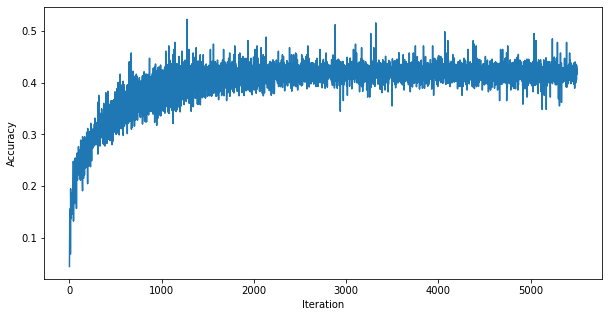

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

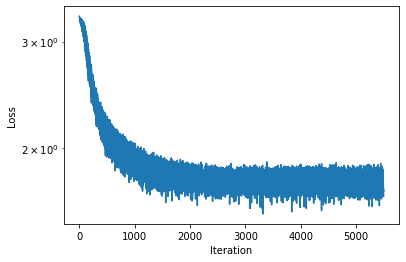

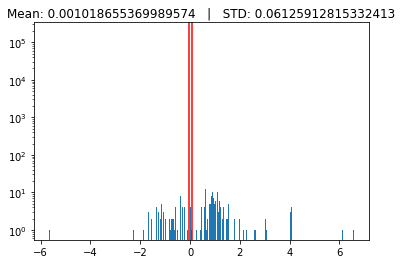

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

In [18]:
import sys
sys.executable

'/usr/bin/python3'

# Tree Visualization

Average height: 7.763440860215054


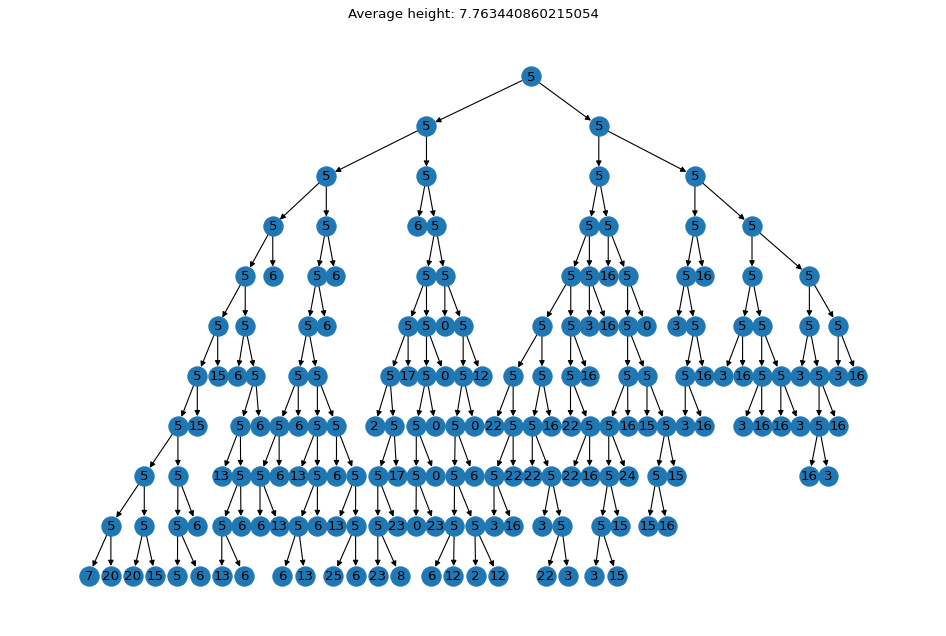

In [19]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [24]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 93


In [25]:
method = 'MLE'

In [26]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

# Tighten boundaries

In [27]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0
comprehensibilities = []
for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    comprehensibilities.append(sum([cond.comprehensibility for cond in conds]))
    
print(f"Average comprehensibility: {np.mean(comprehensibilities)}")
print(f"std comprehensibility: {np.std(comprehensibilities)}")
print(f"var comprehensibility: {np.var(comprehensibilities)}")
print(f"minimum comprehensibility: {np.min(comprehensibilities)}")
print(f"maximum comprehensibility: {np.max(comprehensibilities)}")

============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
131
============== Pattern 8 ==============
66
============== Pattern 9 ==============
============== Pattern 10 ==============
3
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== P